# Simple Gaussian Processes

In this notebook, we will reproduce the [celerite2 tutorial](https://celerite2.readthedocs.io/en/latest/tutorials/first/) with emcee.
The goal is to demonstrate how `simple` can be used for models more complicated than [a Gaussian](./getting-started.ipynb) or [a straight line](./fit_line.ipynb).

## Simulated data

This is copied directly from the [celerite2 tutorial](https://celerite2.readthedocs.io/en/latest/tutorials/first/).

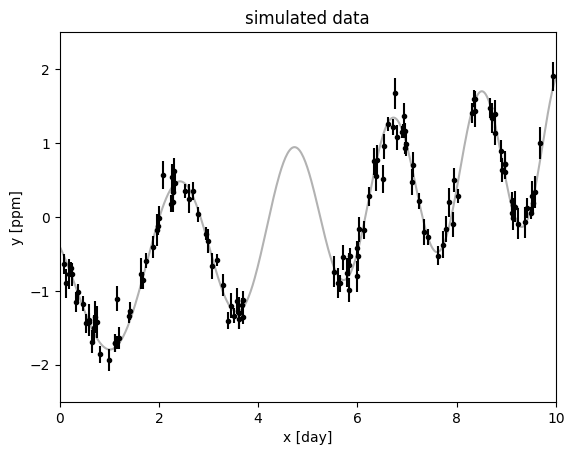

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t - 5) + np.sin(3 * t + 0.1 * (t - 5) ** 2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 500)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")
plt.show()

## GP Definition

This is also copied from the [celerite2 tutorial](https://celerite2.readthedocs.io/en/latest/tutorials/first/).

In [2]:
from celerite2 import GaussianProcess, terms

# Quasi-periodic term
term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

# Non-periodic component
term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = GaussianProcess(kernel, mean=0.0)
gp.compute(t, yerr=yerr)

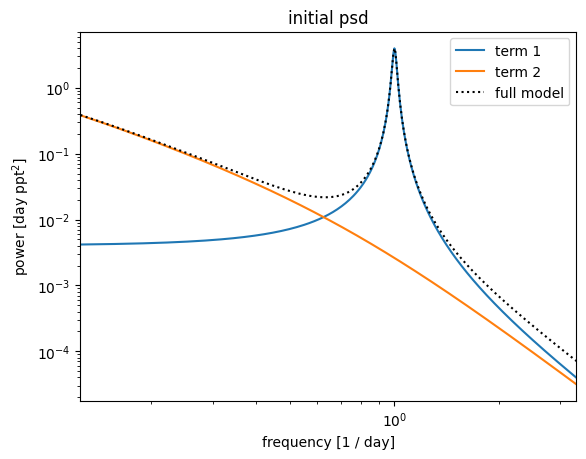

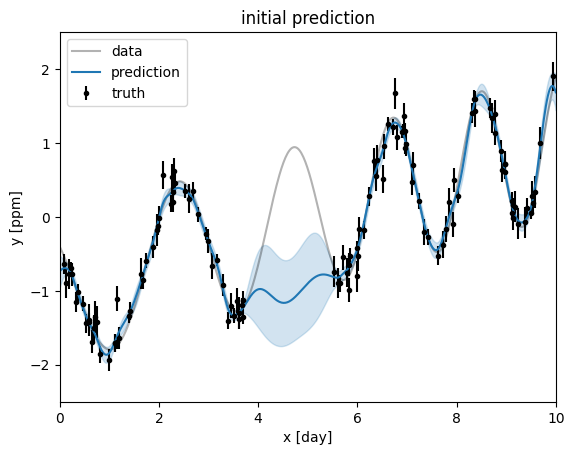

In [3]:
freq = np.linspace(1.0 / 8, 1.0 / 0.3, 500)
omega = 2 * np.pi * freq


def plot_psd(gp):
    for n, term in enumerate(gp.kernel.terms):
        plt.loglog(freq, term.get_psd(omega), label=f"term {n + 1}")
    plt.loglog(freq, gp.kernel.get_psd(omega), ":k", label="full model")
    plt.xlim(freq.min(), freq.max())
    plt.legend()
    plt.xlabel("frequency [1 / day]")
    plt.ylabel("power [day ppt$^2$]")


plt.title("initial psd")
plot_psd(gp)
plt.show()


def plot_prediction(gp):
    plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="data")
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = gp.predict(y, t=true_t, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(true_t, mu, label="prediction")
        plt.fill_between(true_t, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    plt.xlim(0, 10)
    plt.ylim(-2.5, 2.5)
    plt.legend()


plt.title("initial prediction")
plot_prediction(gp)
plt.show()

## Celerite2 model with `simple`

The [celerite2 tutorial](https://celerite2.readthedocs.io/en/latest/tutorials/first/) also defined a `set_params()` function to update the GP parameters before re-computing the likelihood.
Here we modified this function to work with a dictionary instead of an array.

We can then use it inside our `log_likelihood` function that we pass to `simple.Model`.
We use a wide normal prior on all parameters.

In [4]:
from scipy.stats import norm

import simple.model as sm
from simple.distributions import ScipyDistribution


def set_params(params: dict, gp: GaussianProcess, t: np.ndarray, yerr: np.ndarray):
    gp.mean = params["mean"]
    theta = {k: np.exp(v) for k, v in params.items()}
    gp.kernel = terms.SHOTerm(
        sigma=theta["log_sigma_per"], rho=theta["log_rho_per"], tau=theta["log_tau_per"]
    ) + terms.SHOTerm(sigma=theta["log_sigma_non"], rho=theta["log_rho_non"], Q=0.25)
    gp.compute(t, diag=yerr**2 + theta["log_sigma2"], quiet=True)
    return gp


def log_likelihood(
    params: dict, gp: GaussianProcess, t: np.ndarray, y: np.ndarray, yerr: np.ndarray
):
    gp = set_params(params, gp, t, yerr)
    return gp.log_likelihood(y)


prior_dist = norm(0, 2)
parameters = {
    "mean": ScipyDistribution(prior_dist),
    "log_sigma_per": ScipyDistribution(prior_dist),
    "log_rho_per": ScipyDistribution(prior_dist),
    "log_tau_per": ScipyDistribution(prior_dist),
    "log_sigma_non": ScipyDistribution(prior_dist),
    "log_rho_non": ScipyDistribution(prior_dist),
    "log_sigma2": ScipyDistribution(prior_dist),
}

model = sm.Model(parameters, log_likelihood)

## Prior check

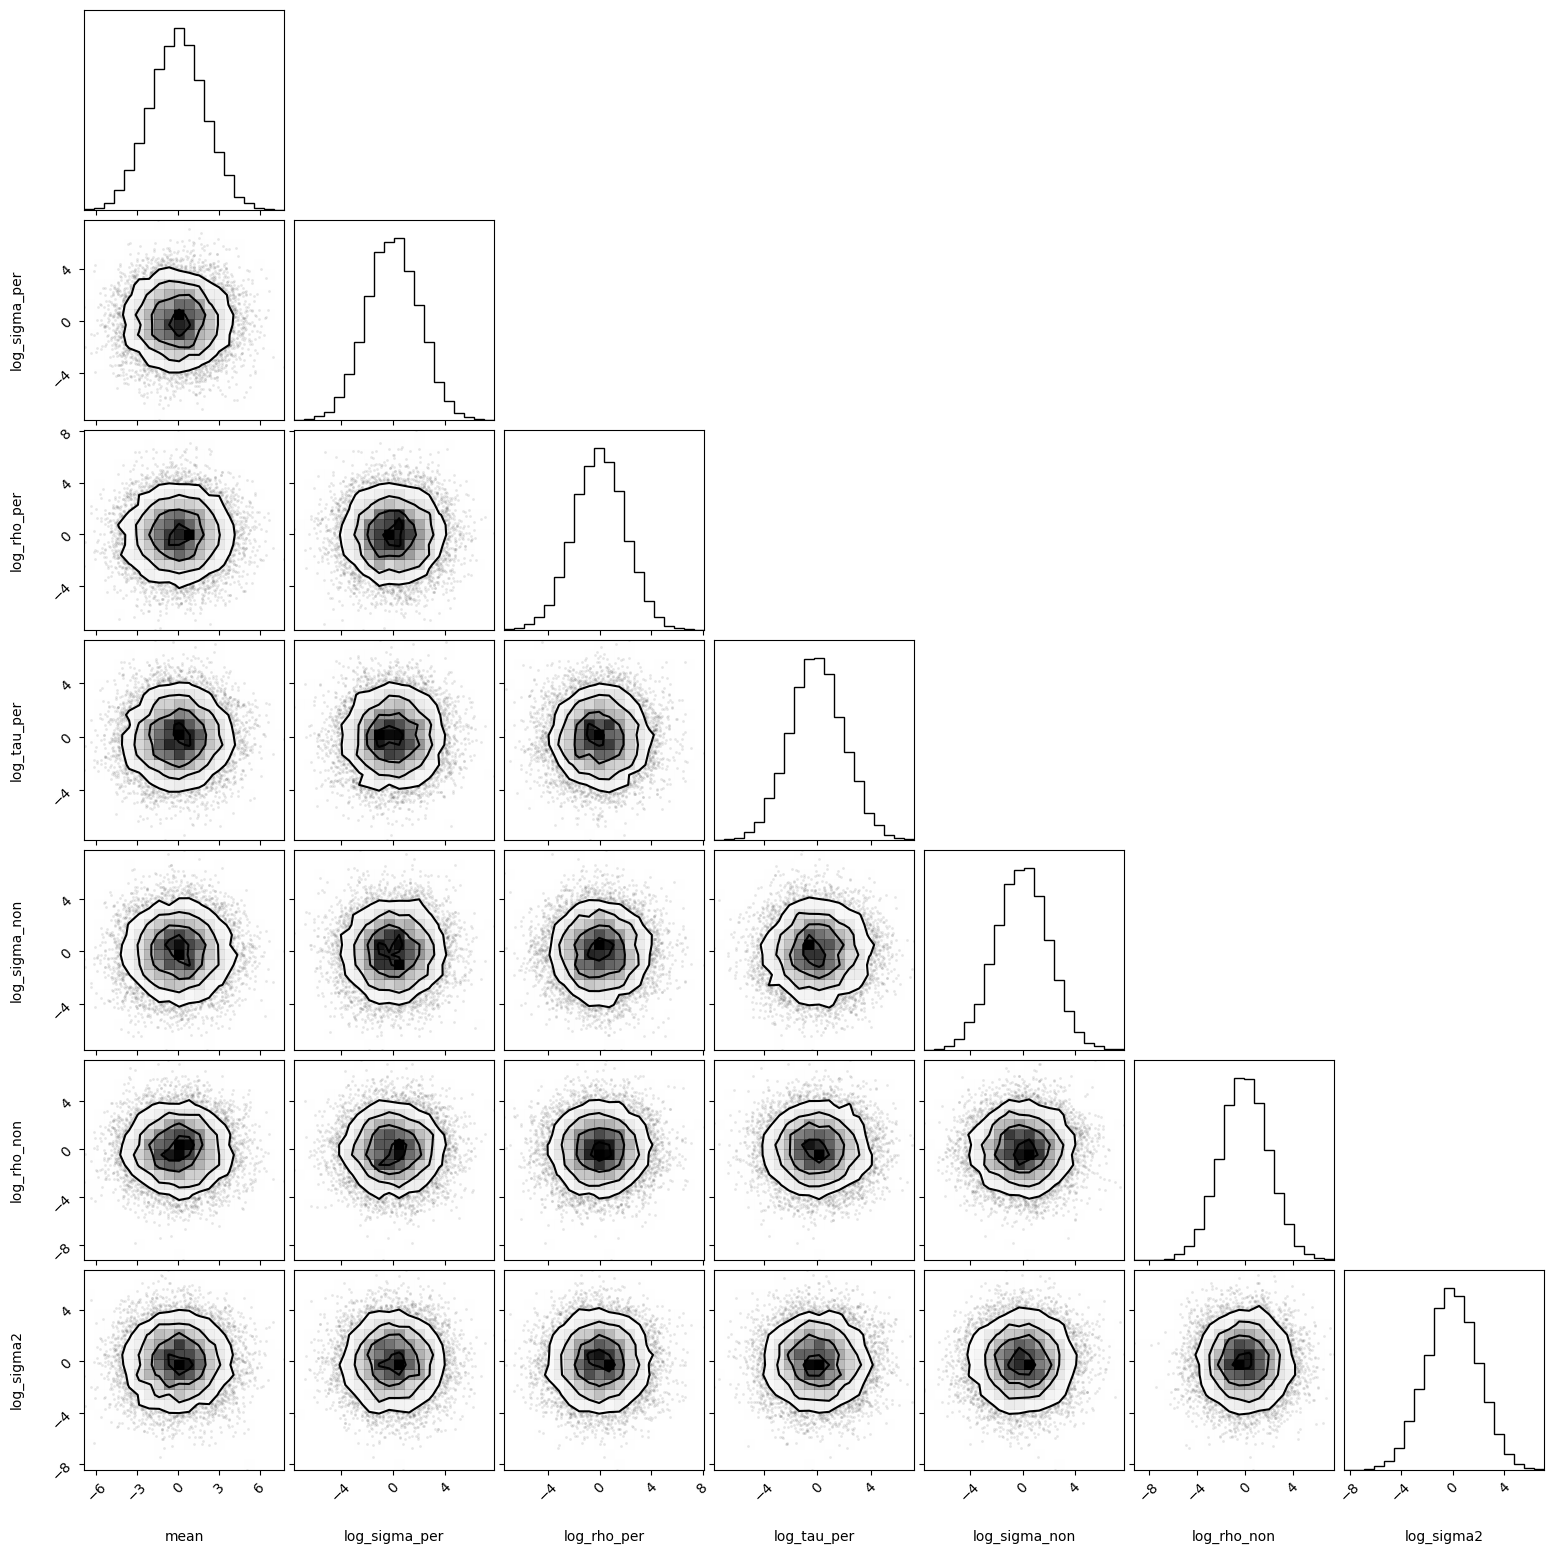

In [5]:
import corner

prior_samples = model.get_prior_samples(10000)
corner.corner(prior_samples)
plt.show()

## Maximum likelihood with scipy

In addition to the sampliong libraries used in previous tutorials, we can use `simple` along with Scipy optimizer.
We only need to adapt the log-likelihood function, either by wrapping it in a `neg_log_likelihood` function or using a `lambda` function, as we do below.

In [6]:
from scipy.optimize import minimize

initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(
    lambda p: -model.log_likelihood(p, gp, t, y, yerr),
    initial_params,
    method="L-BFGS-B",
)
soln_dict = dict(zip(model.keys(), soln.x, strict=True))
opt_gp = set_params(soln_dict, gp, t, yerr)
soln

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -15.942825677433746
        x: [ 5.230e-03 -3.414e-01  7.000e-01  1.944e+00  6.048e-01
             3.754e+00 -7.872e+00]
      nit: 45
      jac: [ 1.592e-04 -6.096e-04  6.155e-03  9.564e-04 -8.669e-05
            -4.320e-04  5.400e-05]
     nfev: 400
     njev: 50
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

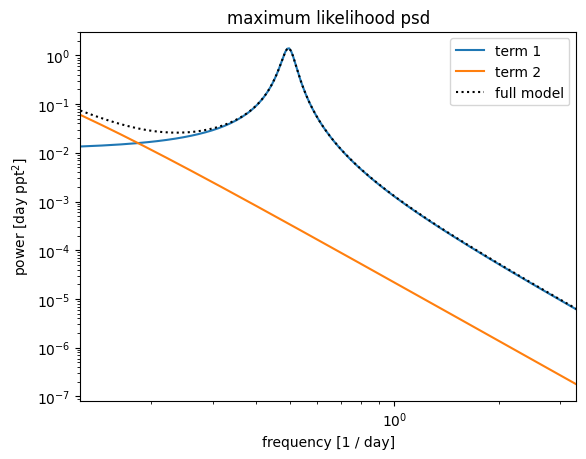

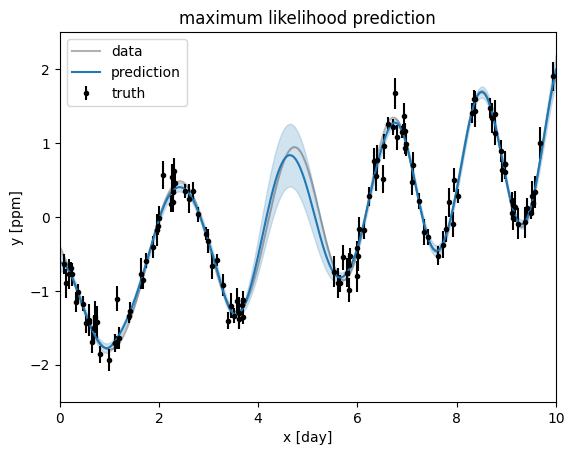

In [7]:
plt.figure()
plt.title("maximum likelihood psd")
plot_psd(opt_gp)
plt.show()

plt.figure()
plt.title("maximum likelihood prediction")
plot_prediction(opt_gp)
plt.show()

## Sampling with emcee

And finally, we can sample the GP model with `emcee`.

In [8]:
import emcee

np.random.seed(5693854)
coords = soln.x + 1e-5 * np.random.randn(32, len(soln.x))
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], model.log_prob, args=(gp, t, y, yerr)
)
sampler.run_mcmc(coords, 7000, progress=True);

  0%|                                                                                                                                                                                                                                                                                              | 0/7000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                                                                                                     | 7/7000 [00:00<01:54, 60.99it/s]

  0%|▌                                                                                                                                                                                                                                                                                    | 14/7000 [00:00<01:54, 61.13it/s]

  0%|▊                                                                                                                                                                                                                                                                                    | 21/7000 [00:00<01:54, 61.06it/s]

  0%|█                                                                                                                                                                                                                                                                                    | 28/7000 [00:00<01:54, 60.70it/s]

  0%|█▍                                                                                                                                                                                                                                                                                   | 35/7000 [00:00<01:55, 60.45it/s]

  1%|█▋                                                                                                                                                                                                                                                                                   | 42/7000 [00:00<01:55, 60.13it/s]

  1%|█▉                                                                                                                                                                                                                                                                                   | 49/7000 [00:00<01:55, 60.04it/s]

  1%|██▏                                                                                                                                                                                                                                                                                  | 56/7000 [00:00<01:58, 58.60it/s]

  1%|██▍                                                                                                                                                                                                                                                                                  | 62/7000 [00:01<01:58, 58.33it/s]

  1%|██▋                                                                                                                                                                                                                                                                                  | 68/7000 [00:01<01:59, 57.88it/s]

  1%|██▉                                                                                                                                                                                                                                                                                  | 74/7000 [00:01<02:02, 56.31it/s]

  1%|███▏                                                                                                                                                                                                                                                                                 | 80/7000 [00:01<02:07, 54.19it/s]

  1%|███▍                                                                                                                                                                                                                                                                                 | 86/7000 [00:01<02:09, 53.23it/s]

  1%|███▋                                                                                                                                                                                                                                                                                 | 92/7000 [00:01<02:08, 53.81it/s]

  1%|███▉                                                                                                                                                                                                                                                                                 | 98/7000 [00:01<02:08, 53.82it/s]

  1%|████                                                                                                                                                                                                                                                                                | 104/7000 [00:01<02:07, 54.21it/s]

  2%|████▎                                                                                                                                                                                                                                                                               | 110/7000 [00:01<02:08, 53.47it/s]

  2%|████▌                                                                                                                                                                                                                                                                               | 116/7000 [00:02<02:10, 52.73it/s]

  2%|████▊                                                                                                                                                                                                                                                                               | 122/7000 [00:02<02:07, 54.11it/s]

  2%|█████                                                                                                                                                                                                                                                                               | 128/7000 [00:02<02:04, 55.33it/s]

  2%|█████▎                                                                                                                                                                                                                                                                              | 134/7000 [00:02<02:01, 56.43it/s]

  2%|█████▌                                                                                                                                                                                                                                                                              | 140/7000 [00:02<02:00, 57.11it/s]

  2%|█████▊                                                                                                                                                                                                                                                                              | 146/7000 [00:02<01:59, 57.30it/s]

  2%|█████▉                                                                                                                                                                                                                                                                              | 152/7000 [00:02<01:58, 57.71it/s]

  2%|██████▏                                                                                                                                                                                                                                                                             | 158/7000 [00:02<01:57, 58.21it/s]

  2%|██████▍                                                                                                                                                                                                                                                                             | 164/7000 [00:02<01:56, 58.55it/s]

  2%|██████▋                                                                                                                                                                                                                                                                             | 170/7000 [00:02<01:56, 58.73it/s]

  3%|██████▉                                                                                                                                                                                                                                                                             | 176/7000 [00:03<01:58, 57.35it/s]

  3%|███████▏                                                                                                                                                                                                                                                                            | 182/7000 [00:03<01:59, 57.05it/s]

  3%|███████▍                                                                                                                                                                                                                                                                            | 188/7000 [00:03<01:59, 57.02it/s]

  3%|███████▋                                                                                                                                                                                                                                                                            | 194/7000 [00:03<01:58, 57.62it/s]

  3%|███████▉                                                                                                                                                                                                                                                                            | 200/7000 [00:03<01:59, 56.80it/s]

  3%|████████                                                                                                                                                                                                                                                                            | 206/7000 [00:03<02:00, 56.40it/s]

  3%|████████▎                                                                                                                                                                                                                                                                           | 212/7000 [00:03<01:59, 56.97it/s]

  3%|████████▌                                                                                                                                                                                                                                                                           | 218/7000 [00:03<01:57, 57.54it/s]

  3%|████████▊                                                                                                                                                                                                                                                                           | 224/7000 [00:03<01:58, 57.14it/s]

  3%|█████████                                                                                                                                                                                                                                                                           | 230/7000 [00:04<01:57, 57.68it/s]

  3%|█████████▎                                                                                                                                                                                                                                                                          | 236/7000 [00:04<01:57, 57.65it/s]

  3%|█████████▌                                                                                                                                                                                                                                                                          | 242/7000 [00:04<01:57, 57.59it/s]

  4%|█████████▊                                                                                                                                                                                                                                                                          | 249/7000 [00:04<01:54, 58.72it/s]

  4%|██████████                                                                                                                                                                                                                                                                          | 256/7000 [00:04<01:53, 59.18it/s]

  4%|██████████▎                                                                                                                                                                                                                                                                         | 263/7000 [00:04<01:53, 59.55it/s]

  4%|██████████▌                                                                                                                                                                                                                                                                         | 269/7000 [00:04<01:53, 59.55it/s]

  4%|██████████▉                                                                                                                                                                                                                                                                         | 276/7000 [00:04<01:52, 59.76it/s]

  4%|███████████▏                                                                                                                                                                                                                                                                        | 283/7000 [00:04<01:51, 59.99it/s]

  4%|███████████▍                                                                                                                                                                                                                                                                        | 290/7000 [00:05<01:51, 60.23it/s]

  4%|███████████▋                                                                                                                                                                                                                                                                        | 297/7000 [00:05<01:50, 60.50it/s]

  4%|███████████▉                                                                                                                                                                                                                                                                        | 304/7000 [00:05<01:50, 60.73it/s]

  4%|████████████▎                                                                                                                                                                                                                                                                       | 311/7000 [00:05<01:52, 59.66it/s]

  5%|████████████▍                                                                                                                                                                                                                                                                       | 317/7000 [00:05<01:52, 59.32it/s]

  5%|████████████▊                                                                                                                                                                                                                                                                       | 324/7000 [00:05<01:51, 59.73it/s]

  5%|█████████████                                                                                                                                                                                                                                                                       | 331/7000 [00:05<01:50, 60.16it/s]

  5%|█████████████▎                                                                                                                                                                                                                                                                      | 338/7000 [00:05<01:50, 60.16it/s]

  5%|█████████████▌                                                                                                                                                                                                                                                                      | 345/7000 [00:05<01:53, 58.58it/s]

  5%|█████████████▉                                                                                                                                                                                                                                                                      | 352/7000 [00:06<01:52, 59.18it/s]

  5%|██████████████▏                                                                                                                                                                                                                                                                     | 359/7000 [00:06<01:51, 59.72it/s]

  5%|██████████████▍                                                                                                                                                                                                                                                                     | 366/7000 [00:06<01:50, 60.22it/s]

  5%|██████████████▋                                                                                                                                                                                                                                                                     | 373/7000 [00:06<01:49, 60.76it/s]

  5%|██████████████▉                                                                                                                                                                                                                                                                     | 380/7000 [00:06<01:49, 60.37it/s]

  6%|███████████████▎                                                                                                                                                                                                                                                                    | 387/7000 [00:06<01:49, 60.59it/s]

  6%|███████████████▌                                                                                                                                                                                                                                                                    | 394/7000 [00:06<01:54, 57.67it/s]

  6%|███████████████▊                                                                                                                                                                                                                                                                    | 400/7000 [00:06<01:54, 57.46it/s]

  6%|████████████████                                                                                                                                                                                                                                                                    | 406/7000 [00:06<01:53, 58.09it/s]

  6%|████████████████▏                                                                                                                                                                                                                                                                   | 412/7000 [00:07<01:55, 57.16it/s]

  6%|████████████████▍                                                                                                                                                                                                                                                                   | 418/7000 [00:07<02:13, 49.24it/s]

  6%|████████████████▋                                                                                                                                                                                                                                                                   | 424/7000 [00:07<02:28, 44.20it/s]

  6%|████████████████▉                                                                                                                                                                                                                                                                   | 429/7000 [00:07<02:33, 42.94it/s]

  6%|█████████████████                                                                                                                                                                                                                                                                   | 434/7000 [00:07<02:28, 44.27it/s]

  6%|█████████████████▎                                                                                                                                                                                                                                                                  | 439/7000 [00:07<02:23, 45.67it/s]

  6%|█████████████████▌                                                                                                                                                                                                                                                                  | 445/7000 [00:07<02:14, 48.79it/s]

  6%|█████████████████▊                                                                                                                                                                                                                                                                  | 451/7000 [00:07<02:07, 51.38it/s]

  7%|██████████████████                                                                                                                                                                                                                                                                  | 457/7000 [00:08<02:06, 51.81it/s]

  7%|██████████████████▎                                                                                                                                                                                                                                                                 | 463/7000 [00:08<02:03, 52.94it/s]

  7%|██████████████████▍                                                                                                                                                                                                                                                                 | 469/7000 [00:08<02:04, 52.60it/s]

  7%|██████████████████▋                                                                                                                                                                                                                                                                 | 475/7000 [00:08<02:06, 51.53it/s]

  7%|██████████████████▉                                                                                                                                                                                                                                                                 | 481/7000 [00:08<02:09, 50.44it/s]

  7%|███████████████████▏                                                                                                                                                                                                                                                                | 487/7000 [00:08<02:08, 50.87it/s]

  7%|███████████████████▍                                                                                                                                                                                                                                                                | 493/7000 [00:08<02:05, 51.74it/s]

  7%|███████████████████▋                                                                                                                                                                                                                                                                | 499/7000 [00:08<02:06, 51.23it/s]

  7%|███████████████████▉                                                                                                                                                                                                                                                                | 505/7000 [00:09<02:03, 52.59it/s]

  7%|████████████████████▏                                                                                                                                                                                                                                                               | 511/7000 [00:09<02:02, 52.88it/s]

  7%|████████████████████▍                                                                                                                                                                                                                                                               | 517/7000 [00:09<02:00, 53.87it/s]

  7%|████████████████████▌                                                                                                                                                                                                                                                               | 523/7000 [00:09<02:00, 53.97it/s]

  8%|████████████████████▊                                                                                                                                                                                                                                                               | 529/7000 [00:09<01:59, 54.08it/s]

  8%|█████████████████████                                                                                                                                                                                                                                                               | 535/7000 [00:09<02:00, 53.46it/s]

  8%|█████████████████████▎                                                                                                                                                                                                                                                              | 541/7000 [00:09<01:59, 53.88it/s]

  8%|█████████████████████▌                                                                                                                                                                                                                                                              | 547/7000 [00:09<01:59, 53.89it/s]

  8%|█████████████████████▊                                                                                                                                                                                                                                                              | 553/7000 [00:09<01:59, 54.14it/s]

  8%|██████████████████████                                                                                                                                                                                                                                                              | 559/7000 [00:10<02:04, 51.89it/s]

  8%|██████████████████████▎                                                                                                                                                                                                                                                             | 565/7000 [00:10<02:01, 52.99it/s]

  8%|██████████████████████▌                                                                                                                                                                                                                                                             | 571/7000 [00:10<02:25, 44.33it/s]

  8%|██████████████████████▋                                                                                                                                                                                                                                                             | 576/7000 [00:10<02:54, 36.82it/s]

  8%|██████████████████████▉                                                                                                                                                                                                                                                             | 581/7000 [00:10<02:53, 37.08it/s]

  8%|███████████████████████                                                                                                                                                                                                                                                             | 585/7000 [00:10<02:51, 37.44it/s]

  8%|███████████████████████▎                                                                                                                                                                                                                                                            | 590/7000 [00:10<02:40, 39.92it/s]

  8%|███████████████████████▍                                                                                                                                                                                                                                                            | 595/7000 [00:10<02:31, 42.26it/s]

  9%|███████████████████████▋                                                                                                                                                                                                                                                            | 600/7000 [00:11<02:38, 40.27it/s]

  9%|███████████████████████▊                                                                                                                                                                                                                                                            | 605/7000 [00:11<02:41, 39.61it/s]

  9%|████████████████████████                                                                                                                                                                                                                                                            | 610/7000 [00:11<02:46, 38.46it/s]

  9%|████████████████████████▏                                                                                                                                                                                                                                                           | 614/7000 [00:11<02:52, 37.04it/s]

  9%|████████████████████████▎                                                                                                                                                                                                                                                           | 618/7000 [00:11<02:55, 36.26it/s]

  9%|████████████████████████▌                                                                                                                                                                                                                                                           | 622/7000 [00:11<03:02, 34.89it/s]

  9%|████████████████████████▋                                                                                                                                                                                                                                                           | 626/7000 [00:11<03:17, 32.28it/s]

  9%|████████████████████████▊                                                                                                                                                                                                                                                           | 630/7000 [00:11<03:07, 33.98it/s]

  9%|████████████████████████▉                                                                                                                                                                                                                                                           | 634/7000 [00:12<03:00, 35.34it/s]

  9%|█████████████████████████▏                                                                                                                                                                                                                                                          | 639/7000 [00:12<02:51, 37.19it/s]

  9%|█████████████████████████▍                                                                                                                                                                                                                                                          | 644/7000 [00:12<02:40, 39.67it/s]

  9%|█████████████████████████▌                                                                                                                                                                                                                                                          | 649/7000 [00:12<02:35, 40.77it/s]

  9%|█████████████████████████▊                                                                                                                                                                                                                                                          | 654/7000 [00:12<02:32, 41.49it/s]

  9%|█████████████████████████▉                                                                                                                                                                                                                                                          | 659/7000 [00:12<02:30, 42.11it/s]

  9%|██████████████████████████▏                                                                                                                                                                                                                                                         | 664/7000 [00:12<02:29, 42.28it/s]

 10%|██████████████████████████▍                                                                                                                                                                                                                                                         | 669/7000 [00:12<02:34, 41.03it/s]

 10%|██████████████████████████▌                                                                                                                                                                                                                                                         | 674/7000 [00:13<02:29, 42.37it/s]

 10%|██████████████████████████▊                                                                                                                                                                                                                                                         | 679/7000 [00:13<02:24, 43.63it/s]

 10%|██████████████████████████▉                                                                                                                                                                                                                                                         | 684/7000 [00:13<02:23, 43.96it/s]

 10%|███████████████████████████▏                                                                                                                                                                                                                                                        | 689/7000 [00:13<02:21, 44.62it/s]

 10%|███████████████████████████▎                                                                                                                                                                                                                                                        | 694/7000 [00:13<02:22, 44.23it/s]

 10%|███████████████████████████▌                                                                                                                                                                                                                                                        | 699/7000 [00:13<02:25, 43.35it/s]

 10%|███████████████████████████▊                                                                                                                                                                                                                                                        | 704/7000 [00:13<02:27, 42.74it/s]

 10%|███████████████████████████▉                                                                                                                                                                                                                                                        | 709/7000 [00:13<02:28, 42.23it/s]

 10%|████████████████████████████▏                                                                                                                                                                                                                                                       | 714/7000 [00:13<02:31, 41.55it/s]

 10%|████████████████████████████▎                                                                                                                                                                                                                                                       | 719/7000 [00:14<02:28, 42.17it/s]

 10%|████████████████████████████▌                                                                                                                                                                                                                                                       | 724/7000 [00:14<02:24, 43.50it/s]

 10%|████████████████████████████▊                                                                                                                                                                                                                                                       | 730/7000 [00:14<02:16, 45.95it/s]

 11%|█████████████████████████████                                                                                                                                                                                                                                                       | 736/7000 [00:14<02:10, 47.99it/s]

 11%|█████████████████████████████▎                                                                                                                                                                                                                                                      | 742/7000 [00:14<02:04, 50.20it/s]

 11%|█████████████████████████████▍                                                                                                                                                                                                                                                      | 748/7000 [00:14<02:00, 51.72it/s]

 11%|█████████████████████████████▋                                                                                                                                                                                                                                                      | 754/7000 [00:14<01:57, 53.23it/s]

 11%|█████████████████████████████▉                                                                                                                                                                                                                                                      | 760/7000 [00:14<01:54, 54.31it/s]

 11%|██████████████████████████████▏                                                                                                                                                                                                                                                     | 766/7000 [00:14<01:53, 54.92it/s]

 11%|██████████████████████████████▍                                                                                                                                                                                                                                                     | 772/7000 [00:15<01:53, 54.99it/s]

 11%|██████████████████████████████▋                                                                                                                                                                                                                                                     | 778/7000 [00:15<01:53, 54.78it/s]

 11%|██████████████████████████████▉                                                                                                                                                                                                                                                     | 784/7000 [00:15<01:55, 53.72it/s]

 11%|███████████████████████████████▏                                                                                                                                                                                                                                                    | 790/7000 [00:15<01:54, 54.04it/s]

 11%|███████████████████████████████▍                                                                                                                                                                                                                                                    | 796/7000 [00:15<01:54, 54.30it/s]

 11%|███████████████████████████████▌                                                                                                                                                                                                                                                    | 802/7000 [00:15<01:56, 53.27it/s]

 12%|███████████████████████████████▊                                                                                                                                                                                                                                                    | 808/7000 [00:15<01:55, 53.65it/s]

 12%|████████████████████████████████                                                                                                                                                                                                                                                    | 814/7000 [00:15<01:53, 54.31it/s]

 12%|████████████████████████████████▎                                                                                                                                                                                                                                                   | 820/7000 [00:15<01:52, 54.73it/s]

 12%|████████████████████████████████▌                                                                                                                                                                                                                                                   | 826/7000 [00:16<01:51, 55.46it/s]

 12%|████████████████████████████████▊                                                                                                                                                                                                                                                   | 832/7000 [00:16<01:51, 55.18it/s]

 12%|█████████████████████████████████                                                                                                                                                                                                                                                   | 838/7000 [00:16<01:52, 54.91it/s]

 12%|█████████████████████████████████▎                                                                                                                                                                                                                                                  | 844/7000 [00:16<01:52, 54.76it/s]

 12%|█████████████████████████████████▌                                                                                                                                                                                                                                                  | 850/7000 [00:16<01:52, 54.54it/s]

 12%|█████████████████████████████████▊                                                                                                                                                                                                                                                  | 856/7000 [00:16<01:52, 54.59it/s]

 12%|█████████████████████████████████▉                                                                                                                                                                                                                                                  | 862/7000 [00:16<01:51, 55.05it/s]

 12%|██████████████████████████████████▏                                                                                                                                                                                                                                                 | 868/7000 [00:16<01:51, 55.18it/s]

 12%|██████████████████████████████████▍                                                                                                                                                                                                                                                 | 874/7000 [00:16<01:50, 55.62it/s]

 13%|██████████████████████████████████▋                                                                                                                                                                                                                                                 | 880/7000 [00:17<01:48, 56.17it/s]

 13%|██████████████████████████████████▉                                                                                                                                                                                                                                                 | 886/7000 [00:17<01:49, 55.91it/s]

 13%|███████████████████████████████████▏                                                                                                                                                                                                                                                | 892/7000 [00:17<01:50, 55.38it/s]

 13%|███████████████████████████████████▍                                                                                                                                                                                                                                                | 898/7000 [00:17<01:49, 55.67it/s]

 13%|███████████████████████████████████▋                                                                                                                                                                                                                                                | 904/7000 [00:17<01:52, 54.31it/s]

 13%|███████████████████████████████████▉                                                                                                                                                                                                                                                | 910/7000 [00:17<01:51, 54.70it/s]

 13%|████████████████████████████████████                                                                                                                                                                                                                                                | 916/7000 [00:17<01:51, 54.67it/s]

 13%|████████████████████████████████████▎                                                                                                                                                                                                                                               | 922/7000 [00:17<01:50, 55.22it/s]

 13%|████████████████████████████████████▌                                                                                                                                                                                                                                               | 928/7000 [00:17<01:52, 54.21it/s]

 13%|████████████████████████████████████▊                                                                                                                                                                                                                                               | 934/7000 [00:17<01:50, 54.67it/s]

 13%|█████████████████████████████████████                                                                                                                                                                                                                                               | 940/7000 [00:18<01:51, 54.21it/s]

 14%|█████████████████████████████████████▎                                                                                                                                                                                                                                              | 946/7000 [00:18<01:51, 54.12it/s]

 14%|█████████████████████████████████████▌                                                                                                                                                                                                                                              | 953/7000 [00:18<01:48, 55.82it/s]

 14%|█████████████████████████████████████▊                                                                                                                                                                                                                                              | 959/7000 [00:18<01:46, 56.74it/s]

 14%|██████████████████████████████████████                                                                                                                                                                                                                                              | 965/7000 [00:18<01:50, 54.62it/s]

 14%|██████████████████████████████████████▎                                                                                                                                                                                                                                             | 971/7000 [00:18<01:58, 50.94it/s]

 14%|██████████████████████████████████████▌                                                                                                                                                                                                                                             | 977/7000 [00:18<01:56, 51.83it/s]

 14%|██████████████████████████████████████▊                                                                                                                                                                                                                                             | 983/7000 [00:18<01:53, 53.14it/s]

 14%|██████████████████████████████████████▉                                                                                                                                                                                                                                             | 989/7000 [00:19<01:52, 53.20it/s]

 14%|███████████████████████████████████████▎                                                                                                                                                                                                                                            | 996/7000 [00:19<01:48, 55.56it/s]

 14%|███████████████████████████████████████▎                                                                                                                                                                                                                                           | 1002/7000 [00:19<01:48, 55.52it/s]

 14%|███████████████████████████████████████▌                                                                                                                                                                                                                                           | 1008/7000 [00:19<01:49, 54.61it/s]

 14%|███████████████████████████████████████▊                                                                                                                                                                                                                                           | 1014/7000 [00:19<01:46, 56.04it/s]

 15%|████████████████████████████████████████                                                                                                                                                                                                                                           | 1020/7000 [00:19<01:44, 57.06it/s]

 15%|████████████████████████████████████████▎                                                                                                                                                                                                                                          | 1026/7000 [00:19<01:43, 57.89it/s]

 15%|████████████████████████████████████████▌                                                                                                                                                                                                                                          | 1032/7000 [00:19<01:43, 57.58it/s]

 15%|████████████████████████████████████████▊                                                                                                                                                                                                                                          | 1038/7000 [00:19<01:43, 57.72it/s]

 15%|█████████████████████████████████████████                                                                                                                                                                                                                                          | 1044/7000 [00:19<01:43, 57.78it/s]

 15%|█████████████████████████████████████████▎                                                                                                                                                                                                                                         | 1051/7000 [00:20<01:41, 58.61it/s]

 15%|█████████████████████████████████████████▌                                                                                                                                                                                                                                         | 1057/7000 [00:20<01:42, 57.75it/s]

 15%|█████████████████████████████████████████▊                                                                                                                                                                                                                                         | 1063/7000 [00:20<01:42, 58.01it/s]

 15%|█████████████████████████████████████████▉                                                                                                                                                                                                                                         | 1069/7000 [00:20<01:41, 58.33it/s]

 15%|██████████████████████████████████████████▏                                                                                                                                                                                                                                        | 1075/7000 [00:20<01:42, 57.65it/s]

 15%|██████████████████████████████████████████▍                                                                                                                                                                                                                                        | 1081/7000 [00:20<01:42, 57.59it/s]

 16%|██████████████████████████████████████████▋                                                                                                                                                                                                                                        | 1087/7000 [00:20<01:42, 57.64it/s]

 16%|██████████████████████████████████████████▉                                                                                                                                                                                                                                        | 1094/7000 [00:20<01:41, 58.15it/s]

 16%|███████████████████████████████████████████▏                                                                                                                                                                                                                                       | 1100/7000 [00:20<01:43, 57.27it/s]

 16%|███████████████████████████████████████████▍                                                                                                                                                                                                                                       | 1106/7000 [00:21<01:41, 57.91it/s]

 16%|███████████████████████████████████████████▋                                                                                                                                                                                                                                       | 1113/7000 [00:21<01:40, 58.69it/s]

 16%|███████████████████████████████████████████▉                                                                                                                                                                                                                                       | 1119/7000 [00:21<01:40, 58.77it/s]

 16%|████████████████████████████████████████████▏                                                                                                                                                                                                                                      | 1125/7000 [00:21<01:39, 58.85it/s]

 16%|████████████████████████████████████████████▍                                                                                                                                                                                                                                      | 1132/7000 [00:21<01:39, 59.17it/s]

 16%|████████████████████████████████████████████▋                                                                                                                                                                                                                                      | 1138/7000 [00:21<01:39, 59.13it/s]

 16%|████████████████████████████████████████████▉                                                                                                                                                                                                                                      | 1144/7000 [00:21<01:39, 58.97it/s]

 16%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 1151/7000 [00:21<01:38, 59.49it/s]

 17%|█████████████████████████████████████████████▍                                                                                                                                                                                                                                     | 1157/7000 [00:21<01:38, 59.18it/s]

 17%|█████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 1163/7000 [00:22<01:39, 58.86it/s]

 17%|█████████████████████████████████████████████▉                                                                                                                                                                                                                                     | 1169/7000 [00:22<01:43, 56.30it/s]

 17%|██████████████████████████████████████████████▏                                                                                                                                                                                                                                    | 1175/7000 [00:22<01:42, 56.82it/s]

 17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                    | 1181/7000 [00:22<01:41, 57.17it/s]

 17%|██████████████████████████████████████████████▋                                                                                                                                                                                                                                    | 1187/7000 [00:22<01:41, 57.30it/s]

 17%|██████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 1193/7000 [00:22<01:40, 57.63it/s]

 17%|███████████████████████████████████████████████                                                                                                                                                                                                                                    | 1199/7000 [00:22<01:40, 57.75it/s]

 17%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                   | 1205/7000 [00:22<01:43, 55.83it/s]

 17%|███████████████████████████████████████████████▌                                                                                                                                                                                                                                   | 1211/7000 [00:22<01:42, 56.56it/s]

 17%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                   | 1217/7000 [00:22<01:42, 56.20it/s]

 17%|████████████████████████████████████████████████                                                                                                                                                                                                                                   | 1223/7000 [00:23<01:43, 56.07it/s]

 18%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                  | 1229/7000 [00:23<01:41, 57.06it/s]

 18%|████████████████████████████████████████████████▌                                                                                                                                                                                                                                  | 1235/7000 [00:23<01:41, 56.79it/s]

 18%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 1241/7000 [00:23<01:44, 55.14it/s]

 18%|████████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 1247/7000 [00:23<01:42, 56.00it/s]

 18%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                 | 1253/7000 [00:23<01:44, 54.77it/s]

 18%|█████████████████████████████████████████████████▍                                                                                                                                                                                                                                 | 1259/7000 [00:23<01:49, 52.44it/s]

 18%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 1265/7000 [00:23<01:47, 53.25it/s]

 18%|█████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 1271/7000 [00:23<01:49, 52.55it/s]

 18%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 1278/7000 [00:24<01:44, 54.91it/s]

 18%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                                | 1284/7000 [00:24<01:43, 55.36it/s]

 18%|██████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 1290/7000 [00:24<01:42, 55.51it/s]

 19%|██████████████████████████████████████████████████▉                                                                                                                                                                                                                                | 1297/7000 [00:24<01:40, 56.71it/s]

 19%|███████████████████████████████████████████████████▏                                                                                                                                                                                                                               | 1303/7000 [00:24<01:40, 56.60it/s]

 19%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                               | 1309/7000 [00:24<01:40, 56.85it/s]

 19%|███████████████████████████████████████████████████▋                                                                                                                                                                                                                               | 1316/7000 [00:24<01:38, 57.98it/s]

 19%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 1323/7000 [00:24<01:36, 58.68it/s]

 19%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                              | 1330/7000 [00:24<01:35, 59.20it/s]

 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 1336/7000 [00:25<01:35, 59.28it/s]

 19%|████████████████████████████████████████████████████▋                                                                                                                                                                                                                              | 1342/7000 [00:25<01:35, 58.96it/s]

 19%|████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 1349/7000 [00:25<01:35, 59.43it/s]

 19%|█████████████████████████████████████████████████████▏                                                                                                                                                                                                                             | 1355/7000 [00:25<01:35, 59.01it/s]

 19%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                                             | 1361/7000 [00:25<01:35, 58.83it/s]

 20%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                             | 1367/7000 [00:25<01:36, 58.58it/s]

 20%|█████████████████████████████████████████████████████▉                                                                                                                                                                                                                             | 1373/7000 [00:25<01:36, 58.37it/s]

 20%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 1379/7000 [00:25<01:36, 58.43it/s]

 20%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                            | 1386/7000 [00:25<01:35, 59.06it/s]

 20%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 1392/7000 [00:26<01:35, 58.81it/s]

 20%|██████████████████████████████████████████████████████▉                                                                                                                                                                                                                            | 1398/7000 [00:26<01:35, 58.68it/s]

 20%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 1404/7000 [00:26<01:37, 57.62it/s]

 20%|███████████████████████████████████████████████████████▍                                                                                                                                                                                                                           | 1410/7000 [00:26<01:37, 57.63it/s]

 20%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                           | 1416/7000 [00:26<01:36, 58.10it/s]

 20%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                                           | 1422/7000 [00:26<01:35, 58.48it/s]

 20%|████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 1428/7000 [00:26<01:35, 58.21it/s]

 20%|████████████████████████████████████████████████████████▎                                                                                                                                                                                                                          | 1434/7000 [00:26<01:34, 58.68it/s]

 21%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 1441/7000 [00:26<01:34, 59.12it/s]

 21%|████████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 1447/7000 [00:26<01:35, 58.36it/s]

 21%|█████████████████████████████████████████████████████████                                                                                                                                                                                                                          | 1453/7000 [00:27<01:35, 57.93it/s]

 21%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                         | 1459/7000 [00:27<01:35, 58.23it/s]

 21%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                                                         | 1465/7000 [00:27<01:34, 58.70it/s]

 21%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 1472/7000 [00:27<01:33, 59.35it/s]

 21%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                         | 1479/7000 [00:27<01:32, 59.63it/s]

 21%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 1485/7000 [00:27<01:33, 59.30it/s]

 21%|██████████████████████████████████████████████████████████▌                                                                                                                                                                                                                        | 1491/7000 [00:27<01:33, 59.18it/s]

 21%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 1497/7000 [00:27<01:32, 59.35it/s]

 21%|███████████████████████████████████████████████████████████                                                                                                                                                                                                                        | 1504/7000 [00:27<01:32, 59.74it/s]

 22%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                                                       | 1510/7000 [00:28<01:31, 59.76it/s]

 22%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                       | 1517/7000 [00:28<01:31, 59.72it/s]

 22%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                       | 1523/7000 [00:28<01:31, 59.71it/s]

 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 1530/7000 [00:28<01:31, 60.05it/s]

 22%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                      | 1537/7000 [00:28<01:30, 60.07it/s]

 22%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 1544/7000 [00:28<01:30, 59.99it/s]

 22%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                      | 1550/7000 [00:28<01:32, 58.68it/s]

 22%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                     | 1556/7000 [00:28<01:33, 58.52it/s]

 22%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 1563/7000 [00:28<01:31, 59.12it/s]

 22%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                     | 1570/7000 [00:29<01:31, 59.46it/s]

 23%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 1577/7000 [00:29<01:30, 59.85it/s]

 23%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                    | 1583/7000 [00:29<01:30, 59.85it/s]

 23%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                    | 1589/7000 [00:29<01:30, 59.77it/s]

 23%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 1596/7000 [00:29<01:30, 60.00it/s]

 23%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                    | 1603/7000 [00:29<01:29, 60.09it/s]

 23%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 1610/7000 [00:29<01:30, 59.87it/s]

 23%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                   | 1616/7000 [00:29<01:29, 59.82it/s]

 23%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                   | 1623/7000 [00:29<01:29, 59.91it/s]

 23%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                   | 1629/7000 [00:30<01:30, 59.54it/s]

 23%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 1635/7000 [00:30<01:31, 58.86it/s]

 23%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 1641/7000 [00:30<01:30, 59.14it/s]

 24%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 1647/7000 [00:30<01:31, 58.34it/s]

 24%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                  | 1653/7000 [00:30<01:31, 58.39it/s]

 24%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                 | 1659/7000 [00:30<01:30, 58.82it/s]

 24%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 1665/7000 [00:30<01:30, 58.73it/s]

 24%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                 | 1672/7000 [00:30<01:29, 59.76it/s]

 24%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 1678/7000 [00:30<01:30, 58.99it/s]

 24%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                | 1684/7000 [00:30<01:30, 58.69it/s]

 24%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 1690/7000 [00:31<01:30, 58.72it/s]

 24%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                | 1696/7000 [00:31<01:30, 58.62it/s]

 24%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                | 1702/7000 [00:31<01:30, 58.56it/s]

 24%|███████████████████████████████████████████████████████████████████                                                                                                                                                                                                                | 1708/7000 [00:31<01:34, 56.10it/s]

 24%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 1714/7000 [00:31<01:33, 56.31it/s]

 25%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                               | 1720/7000 [00:31<01:33, 56.63it/s]

 25%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 1726/7000 [00:31<01:32, 56.86it/s]

 25%|████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 1732/7000 [00:31<01:32, 57.02it/s]

 25%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                              | 1738/7000 [00:31<01:31, 57.27it/s]

 25%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                              | 1744/7000 [00:32<01:31, 57.24it/s]

 25%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 1750/7000 [00:32<01:31, 57.21it/s]

 25%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                              | 1756/7000 [00:32<01:31, 57.34it/s]

 25%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 1762/7000 [00:32<01:31, 57.51it/s]

 25%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                             | 1768/7000 [00:32<01:30, 57.76it/s]

 25%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                             | 1774/7000 [00:32<01:31, 57.16it/s]

 25%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                             | 1780/7000 [00:32<01:32, 56.73it/s]

 26%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                            | 1786/7000 [00:32<01:32, 56.48it/s]

 26%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 1792/7000 [00:32<01:31, 56.77it/s]

 26%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                            | 1798/7000 [00:32<01:31, 56.90it/s]

 26%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                            | 1804/7000 [00:33<01:33, 55.67it/s]

 26%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                                                            | 1810/7000 [00:33<01:32, 55.91it/s]

 26%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                           | 1816/7000 [00:33<01:31, 56.38it/s]

 26%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                           | 1822/7000 [00:33<01:31, 56.88it/s]

 26%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 1828/7000 [00:33<01:30, 57.12it/s]

 26%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                           | 1834/7000 [00:33<01:30, 57.38it/s]

 26%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 1840/7000 [00:33<01:30, 57.21it/s]

 26%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                          | 1846/7000 [00:33<01:30, 56.83it/s]

 26%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 1852/7000 [00:33<01:30, 57.10it/s]

 27%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                          | 1858/7000 [00:34<01:30, 56.61it/s]

 27%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 1864/7000 [00:34<01:30, 56.96it/s]

 27%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                         | 1870/7000 [00:34<01:29, 57.09it/s]

 27%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 1876/7000 [00:34<01:29, 56.99it/s]

 27%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                         | 1882/7000 [00:34<01:29, 57.28it/s]

 27%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                        | 1888/7000 [00:34<01:29, 57.18it/s]

 27%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 1894/7000 [00:34<01:29, 56.83it/s]

 27%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 1900/7000 [00:34<01:29, 56.96it/s]

 27%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                        | 1906/7000 [00:34<01:30, 56.02it/s]

 27%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 1912/7000 [00:34<01:30, 56.11it/s]

 27%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 1918/7000 [00:35<01:30, 56.28it/s]

 27%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                       | 1924/7000 [00:35<01:29, 56.62it/s]

 28%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                       | 1930/7000 [00:35<01:29, 56.87it/s]

 28%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                       | 1936/7000 [00:35<01:29, 56.87it/s]

 28%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 1942/7000 [00:35<01:28, 57.06it/s]

 28%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                      | 1948/7000 [00:35<01:28, 56.97it/s]

 28%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 1954/7000 [00:35<01:28, 56.97it/s]

 28%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 1960/7000 [00:35<01:30, 56.00it/s]

 28%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                     | 1966/7000 [00:35<01:31, 54.81it/s]

 28%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 1972/7000 [00:36<01:36, 51.88it/s]

 28%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 1978/7000 [00:36<01:34, 52.91it/s]

 28%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                     | 1984/7000 [00:36<01:32, 54.08it/s]

 28%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 1990/7000 [00:36<01:30, 55.06it/s]

 29%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 1996/7000 [00:36<01:29, 55.74it/s]

 29%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 2002/7000 [00:36<01:28, 56.24it/s]

 29%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 2008/7000 [00:36<01:29, 55.76it/s]

 29%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 2014/7000 [00:36<01:29, 56.00it/s]

 29%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 2020/7000 [00:36<01:28, 56.40it/s]

 29%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 2026/7000 [00:37<01:27, 56.75it/s]

 29%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                   | 2032/7000 [00:37<01:26, 57.17it/s]

 29%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 2038/7000 [00:37<01:27, 56.48it/s]

 29%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                  | 2044/7000 [00:37<01:27, 56.42it/s]

 29%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 2050/7000 [00:37<01:27, 56.54it/s]

 29%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                  | 2056/7000 [00:37<01:27, 56.76it/s]

 29%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                  | 2062/7000 [00:37<01:26, 56.82it/s]

 30%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 2068/7000 [00:37<01:26, 57.06it/s]

 30%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 2074/7000 [00:37<01:26, 57.00it/s]

 30%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                 | 2080/7000 [00:37<01:26, 57.21it/s]

 30%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 2086/7000 [00:38<01:25, 57.24it/s]

 30%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 2092/7000 [00:38<01:25, 57.52it/s]

 30%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 2098/7000 [00:38<01:24, 57.68it/s]

 30%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 2104/7000 [00:38<01:24, 57.69it/s]

 30%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                | 2110/7000 [00:38<01:25, 57.49it/s]

 30%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 2116/7000 [00:38<01:25, 57.42it/s]

 30%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 2122/7000 [00:38<01:25, 57.22it/s]

 30%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 2128/7000 [00:38<01:25, 57.28it/s]

 30%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                               | 2134/7000 [00:38<01:24, 57.37it/s]

 31%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 2141/7000 [00:39<01:22, 58.62it/s]

 31%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 2148/7000 [00:39<01:21, 59.56it/s]

 31%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                              | 2155/7000 [00:39<01:20, 60.20it/s]

 31%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 2162/7000 [00:39<01:20, 60.11it/s]

 31%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                             | 2169/7000 [00:39<01:21, 59.45it/s]

 31%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 2176/7000 [00:39<01:20, 59.77it/s]

 31%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                             | 2182/7000 [00:39<01:21, 59.33it/s]

 31%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                             | 2189/7000 [00:39<01:20, 59.66it/s]

 31%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 2195/7000 [00:39<01:20, 59.65it/s]

 31%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 2201/7000 [00:40<01:20, 59.68it/s]

 32%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 2208/7000 [00:40<01:19, 59.94it/s]

 32%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                            | 2214/7000 [00:40<01:20, 59.73it/s]

 32%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 2221/7000 [00:40<01:19, 59.99it/s]

 32%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 2228/7000 [00:40<01:19, 60.22it/s]

 32%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                           | 2235/7000 [00:40<01:19, 60.09it/s]

 32%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 2242/7000 [00:40<01:19, 59.56it/s]

 32%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 2248/7000 [00:40<01:19, 59.65it/s]

 32%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 2255/7000 [00:40<01:19, 59.85it/s]

 32%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                          | 2262/7000 [00:41<01:18, 60.04it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 2269/7000 [00:41<01:18, 60.27it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 2276/7000 [00:41<01:18, 60.47it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 2283/7000 [00:41<01:17, 60.57it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 2290/7000 [00:41<01:18, 60.06it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                        | 2297/7000 [00:41<01:18, 60.22it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                        | 2304/7000 [00:41<01:18, 59.89it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 2310/7000 [00:41<01:18, 59.57it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 2317/7000 [00:41<01:18, 59.84it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 2323/7000 [00:42<01:18, 59.62it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                       | 2329/7000 [00:42<01:18, 59.66it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                       | 2336/7000 [00:42<01:17, 60.00it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 2343/7000 [00:42<01:17, 60.33it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 2350/7000 [00:42<01:16, 60.45it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 2357/7000 [00:42<01:16, 60.67it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 2364/7000 [00:42<01:21, 56.79it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 2370/7000 [00:42<01:20, 57.56it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 2377/7000 [00:42<01:19, 58.46it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 2383/7000 [00:43<01:20, 57.69it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                     | 2389/7000 [00:43<01:19, 57.64it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 2395/7000 [00:43<01:19, 57.69it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                    | 2401/7000 [00:43<01:20, 57.13it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                    | 2407/7000 [00:43<01:20, 57.37it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 2414/7000 [00:43<01:18, 58.32it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                    | 2420/7000 [00:43<01:18, 58.33it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 2427/7000 [00:43<01:17, 58.95it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 2433/7000 [00:43<01:17, 59.22it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 2439/7000 [00:44<01:17, 59.14it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 2445/7000 [00:44<01:16, 59.37it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 2452/7000 [00:44<01:16, 59.68it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 2458/7000 [00:44<01:16, 59.38it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                  | 2464/7000 [00:44<01:16, 59.20it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 2471/7000 [00:44<01:16, 59.44it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 2477/7000 [00:44<01:16, 59.41it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 2483/7000 [00:44<01:16, 58.81it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 2489/7000 [00:44<01:16, 58.81it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 2496/7000 [00:45<01:15, 59.28it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                | 2503/7000 [00:45<01:15, 59.65it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 2509/7000 [00:45<01:15, 59.52it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                | 2516/7000 [00:45<01:15, 59.72it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 2522/7000 [00:45<01:15, 59.49it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 2529/7000 [00:45<01:14, 59.89it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 2535/7000 [00:45<01:17, 57.73it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 2541/7000 [00:45<01:17, 57.87it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 2548/7000 [00:45<01:15, 58.71it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 2554/7000 [00:45<01:15, 59.06it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 2561/7000 [00:46<01:14, 59.41it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                              | 2568/7000 [00:46<01:14, 59.87it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 2575/7000 [00:46<01:13, 60.20it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 2582/7000 [00:46<01:13, 59.94it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 2588/7000 [00:46<01:16, 57.30it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                             | 2594/7000 [00:46<01:18, 56.11it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 2600/7000 [00:46<01:17, 56.47it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 2607/7000 [00:46<01:16, 57.80it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 2614/7000 [00:47<01:14, 58.72it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                            | 2620/7000 [00:47<01:14, 59.04it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 2627/7000 [00:47<01:13, 59.44it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 2634/7000 [00:47<01:13, 59.78it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 2641/7000 [00:47<01:12, 60.17it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                           | 2648/7000 [00:47<01:12, 60.44it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 2655/7000 [00:47<01:11, 60.38it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 2662/7000 [00:47<01:12, 60.09it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 2669/7000 [00:47<01:12, 60.12it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 2676/7000 [00:48<01:11, 60.34it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 2683/7000 [00:48<01:11, 60.50it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 2690/7000 [00:48<01:11, 60.55it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                         | 2697/7000 [00:48<01:11, 60.47it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 2704/7000 [00:48<01:11, 60.37it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 2711/7000 [00:48<01:10, 60.44it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 2718/7000 [00:48<01:10, 60.46it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 2725/7000 [00:48<01:11, 60.04it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 2732/7000 [00:48<01:11, 60.05it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 2739/7000 [00:49<01:10, 60.08it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 2746/7000 [00:49<01:10, 60.35it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 2753/7000 [00:49<01:10, 60.64it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 2760/7000 [00:49<01:09, 60.77it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 2767/7000 [00:49<01:10, 60.01it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 2774/7000 [00:49<01:10, 59.81it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 2780/7000 [00:49<01:10, 59.75it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 2786/7000 [00:49<01:12, 57.73it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 2792/7000 [00:49<01:13, 57.61it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 2798/7000 [00:50<01:12, 57.97it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 2804/7000 [00:50<01:12, 57.74it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                    | 2811/7000 [00:50<01:11, 58.74it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 2817/7000 [00:50<01:12, 58.00it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 2824/7000 [00:50<01:11, 58.76it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 2830/7000 [00:50<01:10, 58.82it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                   | 2837/7000 [00:50<01:10, 59.41it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 2843/7000 [00:50<01:09, 59.48it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 2849/7000 [00:50<01:09, 59.48it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 2855/7000 [00:51<01:11, 58.11it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 2862/7000 [00:51<01:10, 58.98it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 2869/7000 [00:51<01:09, 59.58it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 2875/7000 [00:51<01:09, 59.08it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 2881/7000 [00:51<01:09, 59.33it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 2888/7000 [00:51<01:08, 59.60it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 2895/7000 [00:51<01:08, 59.99it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 2901/7000 [00:51<01:11, 57.31it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 2907/7000 [00:51<01:13, 55.73it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 2913/7000 [00:52<01:15, 54.39it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 2919/7000 [00:52<01:14, 54.98it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 2925/7000 [00:52<01:14, 54.54it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 2931/7000 [00:52<01:12, 55.95it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 2937/7000 [00:52<01:12, 56.22it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 2943/7000 [00:52<01:11, 56.38it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 2949/7000 [00:52<01:12, 55.77it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 2955/7000 [00:52<01:14, 54.63it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 2961/7000 [00:52<01:15, 53.52it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 2967/7000 [00:53<01:15, 53.52it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 2973/7000 [00:53<01:15, 53.03it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 2979/7000 [00:53<01:14, 53.69it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 2985/7000 [00:53<01:13, 54.50it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 2991/7000 [00:53<01:12, 55.31it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 2997/7000 [00:53<01:12, 55.46it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 3003/7000 [00:53<01:11, 55.89it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 3009/7000 [00:53<01:15, 52.97it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 3015/7000 [00:54<01:26, 45.91it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 3020/7000 [00:54<01:24, 46.84it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 3025/7000 [00:54<01:23, 47.38it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 3030/7000 [00:54<01:39, 39.78it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 3035/7000 [00:54<01:57, 33.83it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 3039/7000 [00:54<02:08, 30.78it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 3043/7000 [00:54<02:19, 28.40it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 3047/7000 [00:55<02:25, 27.18it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 3050/7000 [00:55<02:27, 26.80it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 3053/7000 [00:55<02:31, 26.08it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 3056/7000 [00:55<02:34, 25.47it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 3059/7000 [00:55<02:37, 25.00it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 3062/7000 [00:55<02:36, 25.13it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 3065/7000 [00:55<02:39, 24.67it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 3068/7000 [00:55<02:39, 24.72it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 3071/7000 [00:56<02:40, 24.51it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 3074/7000 [00:56<02:42, 24.12it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 3077/7000 [00:56<02:43, 23.92it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 3080/7000 [00:56<02:45, 23.75it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 3083/7000 [00:56<02:46, 23.52it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 3086/7000 [00:56<02:50, 23.00it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 3089/7000 [00:56<03:11, 20.46it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 3092/7000 [00:57<03:36, 18.08it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 3094/7000 [00:57<03:53, 16.69it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 3096/7000 [00:57<04:07, 15.76it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 3098/7000 [00:57<04:27, 14.61it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 3100/7000 [00:57<04:39, 13.94it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 3102/7000 [00:57<04:38, 13.99it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 3104/7000 [00:58<04:53, 13.28it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 3106/7000 [00:58<04:59, 12.99it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 3108/7000 [00:58<05:05, 12.76it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 3110/7000 [00:58<05:06, 12.70it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 3112/7000 [00:58<05:08, 12.62it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 3114/7000 [00:58<05:15, 12.32it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 3116/7000 [00:59<05:10, 12.49it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 3118/7000 [00:59<05:07, 12.63it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 3120/7000 [00:59<05:06, 12.68it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 3122/7000 [00:59<05:05, 12.69it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 3124/7000 [00:59<05:02, 12.83it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 3126/7000 [00:59<05:01, 12.84it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 3128/7000 [00:59<05:02, 12.81it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 3130/7000 [01:00<05:07, 12.59it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 3132/7000 [01:00<05:01, 12.83it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 3134/7000 [01:00<05:03, 12.72it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 3136/7000 [01:00<05:03, 12.75it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 3138/7000 [01:00<04:59, 12.90it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 3140/7000 [01:00<05:06, 12.60it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 3142/7000 [01:01<05:09, 12.45it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 3144/7000 [01:01<05:20, 12.02it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 3146/7000 [01:01<05:24, 11.88it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 3148/7000 [01:01<05:21, 12.00it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 3150/7000 [01:01<05:18, 12.08it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 3152/7000 [01:01<05:19, 12.06it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 3154/7000 [01:02<05:19, 12.03it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 3156/7000 [01:02<05:09, 12.43it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                       | 3158/7000 [01:02<05:06, 12.53it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 3160/7000 [01:02<05:10, 12.38it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 3162/7000 [01:02<05:08, 12.46it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 3164/7000 [01:02<05:05, 12.56it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 3166/7000 [01:03<05:02, 12.66it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 3168/7000 [01:03<05:02, 12.67it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 3170/7000 [01:03<05:09, 12.36it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 3172/7000 [01:03<05:18, 12.04it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 3174/7000 [01:03<05:22, 11.85it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 3176/7000 [01:03<05:26, 11.71it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 3178/7000 [01:04<05:30, 11.57it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 3180/7000 [01:04<05:25, 11.74it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 3182/7000 [01:04<05:23, 11.80it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 3184/7000 [01:04<05:25, 11.72it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 3186/7000 [01:04<05:27, 11.64it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 3188/7000 [01:04<05:19, 11.92it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 3190/7000 [01:05<05:12, 12.18it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 3192/7000 [01:05<05:08, 12.34it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 3194/7000 [01:05<05:09, 12.28it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 3196/7000 [01:05<05:14, 12.08it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 3198/7000 [01:05<05:08, 12.31it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 3200/7000 [01:05<05:09, 12.29it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 3202/7000 [01:06<05:04, 12.46it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 3204/7000 [01:06<05:09, 12.26it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 3206/7000 [01:06<05:09, 12.25it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 3208/7000 [01:06<05:11, 12.17it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 3210/7000 [01:06<05:07, 12.33it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 3212/7000 [01:06<05:06, 12.37it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 3214/7000 [01:07<05:03, 12.47it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 3216/7000 [01:07<05:02, 12.52it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 3218/7000 [01:07<04:56, 12.77it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 3220/7000 [01:07<04:28, 14.08it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 3223/7000 [01:07<04:00, 15.72it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 3225/7000 [01:07<04:04, 15.46it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 3227/7000 [01:07<04:09, 15.10it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 3229/7000 [01:08<04:19, 14.55it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 3231/7000 [01:08<04:23, 14.31it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 3233/7000 [01:08<04:27, 14.07it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 3235/7000 [01:08<04:31, 13.88it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 3237/7000 [01:08<04:31, 13.88it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 3239/7000 [01:08<04:29, 13.94it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 3241/7000 [01:08<04:31, 13.84it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 3243/7000 [01:09<04:32, 13.77it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 3245/7000 [01:09<04:28, 14.01it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 3247/7000 [01:09<04:30, 13.89it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 3249/7000 [01:09<04:30, 13.87it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 3251/7000 [01:09<04:35, 13.62it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 3253/7000 [01:09<04:31, 13.82it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 3255/7000 [01:09<04:29, 13.90it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 3257/7000 [01:10<04:34, 13.66it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 3259/7000 [01:10<04:40, 13.32it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 3261/7000 [01:10<04:40, 13.34it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 3263/7000 [01:10<04:37, 13.48it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 3265/7000 [01:10<04:31, 13.78it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 3267/7000 [01:10<04:30, 13.82it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 3269/7000 [01:10<04:35, 13.53it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 3271/7000 [01:11<04:44, 13.13it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 3273/7000 [01:11<04:38, 13.39it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 3275/7000 [01:11<04:34, 13.58it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 3277/7000 [01:11<04:30, 13.77it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 3279/7000 [01:11<04:34, 13.57it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 3281/7000 [01:11<04:35, 13.50it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 3283/7000 [01:11<04:35, 13.49it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 3285/7000 [01:12<04:30, 13.72it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 3287/7000 [01:12<04:32, 13.63it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 3289/7000 [01:12<04:29, 13.77it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 3291/7000 [01:12<04:25, 13.97it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 3293/7000 [01:12<04:24, 14.00it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 3295/7000 [01:12<04:27, 13.84it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 3297/7000 [01:12<04:30, 13.70it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 3299/7000 [01:13<04:26, 13.87it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 3301/7000 [01:13<04:22, 14.11it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 3303/7000 [01:13<04:18, 14.29it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 3305/7000 [01:13<04:17, 14.37it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 3307/7000 [01:13<04:23, 14.01it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 3309/7000 [01:13<04:22, 14.04it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 3311/7000 [01:13<04:27, 13.79it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 3313/7000 [01:14<04:21, 14.13it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 3315/7000 [01:14<04:28, 13.71it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 3317/7000 [01:14<04:29, 13.68it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 3319/7000 [01:14<04:33, 13.48it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 3321/7000 [01:14<04:26, 13.80it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 3323/7000 [01:14<04:23, 13.97it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 3325/7000 [01:14<04:27, 13.75it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 3327/7000 [01:15<04:24, 13.89it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 3329/7000 [01:15<04:29, 13.64it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 3331/7000 [01:15<04:32, 13.48it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 3333/7000 [01:15<04:30, 13.58it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 3335/7000 [01:15<04:27, 13.71it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 3337/7000 [01:15<04:22, 13.96it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 3339/7000 [01:16<04:26, 13.76it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 3341/7000 [01:16<04:29, 13.59it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 3343/7000 [01:16<04:26, 13.71it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 3345/7000 [01:16<04:27, 13.64it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 3347/7000 [01:16<04:33, 13.37it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 3349/7000 [01:16<04:29, 13.52it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 3351/7000 [01:16<04:25, 13.72it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 3353/7000 [01:17<04:27, 13.65it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 3355/7000 [01:17<04:26, 13.69it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 3357/7000 [01:17<04:27, 13.64it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 3359/7000 [01:17<04:24, 13.79it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 3361/7000 [01:17<04:19, 14.04it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 3363/7000 [01:17<04:20, 13.94it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 3365/7000 [01:17<04:28, 13.54it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 3367/7000 [01:18<04:24, 13.75it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 3369/7000 [01:18<04:16, 14.14it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 3371/7000 [01:18<04:16, 14.14it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 3373/7000 [01:18<04:25, 13.65it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 3375/7000 [01:18<04:31, 13.36it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 3377/7000 [01:18<04:24, 13.71it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 3379/7000 [01:18<04:23, 13.77it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 3381/7000 [01:19<04:23, 13.72it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 3383/7000 [01:19<04:19, 13.92it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 3385/7000 [01:19<04:19, 13.91it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 3387/7000 [01:19<04:20, 13.90it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 3389/7000 [01:19<04:21, 13.83it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 3391/7000 [01:19<04:20, 13.86it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 3393/7000 [01:19<04:18, 13.95it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 3395/7000 [01:20<04:20, 13.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 3397/7000 [01:20<04:17, 14.00it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 3399/7000 [01:20<04:17, 14.00it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 3401/7000 [01:20<04:17, 13.98it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 3403/7000 [01:20<04:25, 13.56it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 3405/7000 [01:20<04:25, 13.53it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 3407/7000 [01:20<04:23, 13.63it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 3409/7000 [01:21<04:17, 13.92it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 3411/7000 [01:21<04:14, 14.10it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 3413/7000 [01:21<04:14, 14.08it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 3415/7000 [01:21<04:18, 13.84it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 3417/7000 [01:21<04:24, 13.54it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 3419/7000 [01:21<04:25, 13.51it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 3421/7000 [01:21<04:21, 13.70it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 3423/7000 [01:22<04:23, 13.56it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 3425/7000 [01:22<04:24, 13.54it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 3427/7000 [01:22<04:23, 13.56it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 3429/7000 [01:22<04:21, 13.67it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 3431/7000 [01:22<04:21, 13.65it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 3433/7000 [01:22<04:18, 13.82it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 3435/7000 [01:22<04:15, 13.94it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 3437/7000 [01:23<04:19, 13.72it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 3439/7000 [01:23<04:25, 13.43it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 3441/7000 [01:23<04:28, 13.27it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 3443/7000 [01:23<04:26, 13.34it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 3445/7000 [01:23<04:31, 13.12it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 3447/7000 [01:23<04:39, 12.73it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 3449/7000 [01:24<04:47, 12.37it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 3451/7000 [01:24<04:46, 12.40it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 3454/7000 [01:24<03:56, 15.03it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 3457/7000 [01:24<03:13, 18.30it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 3461/7000 [01:24<02:37, 22.53it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 3465/7000 [01:24<02:13, 26.41it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 3469/7000 [01:24<01:59, 29.62it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 3474/7000 [01:24<01:46, 33.23it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 3479/7000 [01:25<01:37, 36.04it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 3484/7000 [01:25<01:32, 38.00it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 3489/7000 [01:25<01:28, 39.89it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 3494/7000 [01:25<01:25, 41.07it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 3499/7000 [01:25<01:24, 41.50it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 3504/7000 [01:25<01:22, 42.39it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 3509/7000 [01:25<01:20, 43.16it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 3514/7000 [01:25<01:19, 43.68it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 3519/7000 [01:25<01:19, 43.57it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 3524/7000 [01:26<01:19, 43.88it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 3529/7000 [01:26<01:19, 43.43it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 3534/7000 [01:26<01:19, 43.58it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 3539/7000 [01:26<01:18, 43.92it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 3544/7000 [01:26<01:19, 43.73it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 3549/7000 [01:26<01:19, 43.20it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 3554/7000 [01:26<01:19, 43.46it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 3559/7000 [01:26<01:18, 43.60it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 3564/7000 [01:27<01:22, 41.64it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 3569/7000 [01:27<01:43, 33.25it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 3573/7000 [01:27<02:07, 26.97it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 3577/7000 [01:27<02:34, 22.19it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 3580/7000 [01:27<02:53, 19.73it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 3583/7000 [01:28<03:12, 17.80it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 3585/7000 [01:28<03:20, 17.03it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 3587/7000 [01:28<03:27, 16.45it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 3589/7000 [01:28<03:37, 15.68it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 3591/7000 [01:28<03:45, 15.10it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 3593/7000 [01:28<03:52, 14.68it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 3595/7000 [01:29<03:58, 14.27it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 3597/7000 [01:29<04:00, 14.14it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 3599/7000 [01:29<04:02, 14.03it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 3601/7000 [01:29<04:03, 13.98it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 3603/7000 [01:29<04:04, 13.90it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 3605/7000 [01:29<04:07, 13.71it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 3607/7000 [01:29<04:05, 13.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 3609/7000 [01:30<04:05, 13.79it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 3611/7000 [01:30<04:07, 13.68it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 3613/7000 [01:30<04:04, 13.86it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 3615/7000 [01:30<04:04, 13.87it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 3617/7000 [01:30<04:14, 13.31it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 3619/7000 [01:30<04:16, 13.18it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 3621/7000 [01:30<04:17, 13.12it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 3623/7000 [01:31<04:15, 13.22it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 3625/7000 [01:31<04:21, 12.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 3627/7000 [01:31<04:16, 13.16it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 3629/7000 [01:31<04:23, 12.77it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 3631/7000 [01:31<04:35, 12.23it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 3633/7000 [01:31<04:23, 12.76it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 3635/7000 [01:32<04:15, 13.19it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 3637/7000 [01:32<04:11, 13.36it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 3639/7000 [01:32<04:11, 13.34it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 3641/7000 [01:32<04:09, 13.48it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 3643/7000 [01:32<04:10, 13.41it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 3645/7000 [01:32<04:06, 13.62it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 3647/7000 [01:32<04:09, 13.45it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 3649/7000 [01:33<04:13, 13.22it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 3651/7000 [01:33<04:23, 12.70it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 3653/7000 [01:33<04:20, 12.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 3655/7000 [01:33<04:15, 13.08it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 3657/7000 [01:33<04:20, 12.83it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 3659/7000 [01:33<04:20, 12.85it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 3661/7000 [01:34<04:14, 13.12it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 3663/7000 [01:34<04:12, 13.24it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 3665/7000 [01:34<04:12, 13.23it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 3667/7000 [01:34<04:11, 13.23it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 3669/7000 [01:34<04:11, 13.25it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 3671/7000 [01:34<04:14, 13.10it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 3673/7000 [01:34<04:16, 12.97it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 3675/7000 [01:35<04:23, 12.62it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 3677/7000 [01:35<04:19, 12.78it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 3679/7000 [01:35<04:17, 12.87it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 3681/7000 [01:35<04:12, 13.13it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 3683/7000 [01:35<04:10, 13.22it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 3685/7000 [01:35<04:17, 12.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 3687/7000 [01:36<04:30, 12.25it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 3689/7000 [01:36<04:32, 12.15it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 3691/7000 [01:36<04:33, 12.12it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 3693/7000 [01:36<04:29, 12.27it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 3695/7000 [01:36<04:24, 12.48it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 3697/7000 [01:36<04:31, 12.19it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 3699/7000 [01:37<04:32, 12.09it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 3701/7000 [01:37<04:35, 11.96it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 3703/7000 [01:37<04:30, 12.20it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 3705/7000 [01:37<04:25, 12.40it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 3707/7000 [01:37<04:19, 12.68it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 3709/7000 [01:37<04:19, 12.66it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 3711/7000 [01:38<04:27, 12.31it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 3713/7000 [01:38<04:35, 11.93it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 3715/7000 [01:38<04:39, 11.77it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 3717/7000 [01:38<04:44, 11.55it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 3719/7000 [01:38<04:48, 11.38it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 3721/7000 [01:38<04:46, 11.43it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 3723/7000 [01:39<04:40, 11.69it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 3725/7000 [01:39<04:38, 11.75it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 3727/7000 [01:39<04:40, 11.67it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 3729/7000 [01:39<04:46, 11.42it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 3731/7000 [01:39<04:45, 11.45it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 3733/7000 [01:39<04:46, 11.42it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 3735/7000 [01:40<04:52, 11.17it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 3737/7000 [01:40<04:43, 11.51it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 3739/7000 [01:40<04:34, 11.89it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 3741/7000 [01:40<04:24, 12.32it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 3743/7000 [01:40<04:09, 13.04it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 3745/7000 [01:40<04:02, 13.41it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 3747/7000 [01:41<04:03, 13.38it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 3749/7000 [01:41<04:04, 13.30it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 3751/7000 [01:41<04:04, 13.26it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 3753/7000 [01:41<04:10, 12.95it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 3755/7000 [01:41<04:14, 12.76it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 3757/7000 [01:41<04:12, 12.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 3759/7000 [01:41<04:18, 12.52it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 3761/7000 [01:42<04:17, 12.56it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 3763/7000 [01:42<04:16, 12.62it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 3765/7000 [01:42<04:17, 12.58it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 3767/7000 [01:42<04:17, 12.56it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 3769/7000 [01:42<04:10, 12.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 3771/7000 [01:42<04:13, 12.74it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 3773/7000 [01:43<04:10, 12.91it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 3775/7000 [01:43<04:07, 13.02it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 3777/7000 [01:43<04:04, 13.17it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 3779/7000 [01:43<04:11, 12.79it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 3781/7000 [01:43<04:23, 12.21it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 3783/7000 [01:43<04:41, 11.44it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 3785/7000 [01:44<04:27, 12.04it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 3787/7000 [01:44<04:17, 12.48it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 3789/7000 [01:44<04:05, 13.07it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 3791/7000 [01:44<04:02, 13.22it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 3793/7000 [01:44<04:01, 13.28it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 3795/7000 [01:44<03:54, 13.66it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 3797/7000 [01:44<03:51, 13.83it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 3799/7000 [01:45<03:51, 13.81it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 3801/7000 [01:45<03:49, 13.96it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 3803/7000 [01:45<03:48, 14.02it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 3805/7000 [01:45<03:49, 13.92it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 3807/7000 [01:45<03:48, 13.98it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 3809/7000 [01:45<03:45, 14.12it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 3811/7000 [01:45<03:46, 14.05it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 3813/7000 [01:46<03:45, 14.13it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 3815/7000 [01:46<03:45, 14.15it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 3817/7000 [01:46<03:45, 14.11it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 3819/7000 [01:46<03:45, 14.11it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 3821/7000 [01:46<03:46, 14.03it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 3823/7000 [01:46<03:45, 14.11it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 3825/7000 [01:46<03:45, 14.06it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 3827/7000 [01:47<03:47, 13.97it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 3829/7000 [01:47<03:46, 14.01it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 3831/7000 [01:47<03:46, 13.99it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 3833/7000 [01:47<03:47, 13.91it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 3835/7000 [01:47<03:44, 14.11it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 3837/7000 [01:47<03:41, 14.26it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 3839/7000 [01:47<03:43, 14.17it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 3841/7000 [01:48<03:45, 14.04it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 3843/7000 [01:48<03:42, 14.21it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 3845/7000 [01:48<03:42, 14.16it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 3847/7000 [01:48<03:43, 14.09it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 3849/7000 [01:48<03:42, 14.16it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 3851/7000 [01:48<03:43, 14.08it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 3853/7000 [01:48<03:42, 14.12it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 3855/7000 [01:49<03:39, 14.35it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 3857/7000 [01:49<03:35, 14.60it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 3859/7000 [01:49<03:32, 14.78it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 3861/7000 [01:49<03:37, 14.45it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 3863/7000 [01:49<03:39, 14.30it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 3865/7000 [01:49<03:38, 14.37it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 3867/7000 [01:49<03:38, 14.32it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 3869/7000 [01:49<03:35, 14.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 3871/7000 [01:50<03:35, 14.54it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 3873/7000 [01:50<03:34, 14.59it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 3875/7000 [01:50<03:35, 14.47it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 3877/7000 [01:50<03:36, 14.45it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 3879/7000 [01:50<03:38, 14.29it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 3881/7000 [01:50<03:35, 14.46it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 3883/7000 [01:50<03:30, 14.84it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 3885/7000 [01:51<03:27, 15.03it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 3887/7000 [01:51<03:20, 15.53it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 3889/7000 [01:51<03:27, 14.98it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 3891/7000 [01:51<03:30, 14.76it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 3893/7000 [01:51<03:31, 14.72it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 3895/7000 [01:51<03:31, 14.68it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 3897/7000 [01:51<03:32, 14.63it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 3899/7000 [01:52<03:34, 14.46it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 3901/7000 [01:52<03:31, 14.67it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 3903/7000 [01:52<03:25, 15.09it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 3905/7000 [01:52<03:26, 14.98it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 3907/7000 [01:52<03:34, 14.43it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 3909/7000 [01:52<03:35, 14.37it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 3911/7000 [01:52<03:36, 14.26it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 3913/7000 [01:52<03:38, 14.13it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 3915/7000 [01:53<03:41, 13.96it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 3917/7000 [01:53<03:43, 13.77it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 3919/7000 [01:53<03:42, 13.88it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 3921/7000 [01:53<03:39, 14.04it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 3923/7000 [01:53<03:39, 14.01it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 3925/7000 [01:53<03:38, 14.05it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 3927/7000 [01:53<03:31, 14.51it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 3929/7000 [01:54<03:29, 14.69it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 3931/7000 [01:54<03:32, 14.46it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 3933/7000 [01:54<03:33, 14.40it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 3935/7000 [01:54<03:31, 14.46it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 3937/7000 [01:54<03:29, 14.60it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 3939/7000 [01:54<03:33, 14.36it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 3941/7000 [01:54<03:33, 14.30it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 3943/7000 [01:55<03:32, 14.39it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 3945/7000 [01:55<03:32, 14.36it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 3947/7000 [01:55<03:31, 14.46it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 3949/7000 [01:55<03:33, 14.31it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 3951/7000 [01:55<03:33, 14.27it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 3953/7000 [01:55<03:32, 14.31it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 3955/7000 [01:55<03:32, 14.35it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 3957/7000 [01:56<03:33, 14.29it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 3959/7000 [01:56<03:34, 14.19it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 3961/7000 [01:56<03:34, 14.15it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 3963/7000 [01:56<03:33, 14.23it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 3965/7000 [01:56<03:34, 14.15it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 3967/7000 [01:56<03:33, 14.21it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 3969/7000 [01:56<03:34, 14.16it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 3971/7000 [01:57<03:33, 14.18it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 3973/7000 [01:57<03:31, 14.28it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 3975/7000 [01:57<03:32, 14.24it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 3977/7000 [01:57<03:27, 14.58it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 3979/7000 [01:57<03:23, 14.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 3981/7000 [01:57<03:25, 14.69it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 3983/7000 [01:57<03:31, 14.26it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 3985/7000 [01:58<03:35, 13.98it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 3987/7000 [01:58<03:39, 13.70it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 3989/7000 [01:58<03:51, 13.03it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 3991/7000 [01:58<03:54, 12.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 3993/7000 [01:58<03:54, 12.80it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 3995/7000 [01:58<03:49, 13.12it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 3997/7000 [01:58<03:47, 13.22it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 3999/7000 [01:59<03:42, 13.46it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 4001/7000 [01:59<03:42, 13.47it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 4003/7000 [01:59<03:42, 13.49it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 4005/7000 [01:59<03:51, 12.95it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 4007/7000 [01:59<03:56, 12.65it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 4009/7000 [01:59<03:56, 12.62it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 4011/7000 [02:00<03:57, 12.58it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 4013/7000 [02:00<03:59, 12.49it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 4015/7000 [02:00<03:53, 12.77it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 4017/7000 [02:00<04:16, 11.62it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 4019/7000 [02:00<04:05, 12.17it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 4021/7000 [02:00<04:02, 12.27it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 4023/7000 [02:01<03:57, 12.52it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 4025/7000 [02:01<03:50, 12.91it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 4027/7000 [02:01<03:48, 13.02it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 4029/7000 [02:01<03:52, 12.79it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 4031/7000 [02:01<03:51, 12.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 4033/7000 [02:01<03:50, 12.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4035/7000 [02:01<03:53, 12.72it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4037/7000 [02:02<04:01, 12.28it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 4040/7000 [02:02<03:22, 14.62it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 4043/7000 [02:02<02:56, 16.76it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 4046/7000 [02:02<02:42, 18.14it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 4049/7000 [02:02<02:36, 18.86it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 4051/7000 [02:02<02:35, 18.96it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 4054/7000 [02:02<02:30, 19.55it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 4057/7000 [02:03<02:26, 20.11it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 4060/7000 [02:03<02:29, 19.66it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 4062/7000 [02:03<02:29, 19.61it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 4064/7000 [02:03<02:36, 18.71it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 4066/7000 [02:03<02:41, 18.21it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 4069/7000 [02:03<02:35, 18.84it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 4071/7000 [02:03<02:40, 18.30it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 4074/7000 [02:04<02:34, 18.99it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 4076/7000 [02:04<02:39, 18.38it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 4078/7000 [02:04<02:37, 18.51it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 4080/7000 [02:04<02:38, 18.48it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 4082/7000 [02:04<02:46, 17.48it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 4084/7000 [02:04<02:43, 17.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 4087/7000 [02:04<02:32, 19.06it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 4089/7000 [02:04<02:34, 18.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 4092/7000 [02:04<02:27, 19.68it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 4095/7000 [02:05<02:24, 20.14it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 4098/7000 [02:05<02:21, 20.46it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 4101/7000 [02:05<02:21, 20.48it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 4104/7000 [02:05<02:25, 19.85it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 4106/7000 [02:05<02:31, 19.14it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 4109/7000 [02:05<02:27, 19.56it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 4111/7000 [02:05<02:32, 18.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 4113/7000 [02:06<02:37, 18.38it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 4115/7000 [02:06<02:38, 18.21it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 4117/7000 [02:06<02:36, 18.42it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 4119/7000 [02:06<02:40, 17.92it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 4121/7000 [02:06<02:38, 18.15it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 4123/7000 [02:06<02:42, 17.68it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 4125/7000 [02:06<02:37, 18.21it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 4128/7000 [02:06<02:29, 19.27it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 4131/7000 [02:07<02:27, 19.51it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 4133/7000 [02:07<02:29, 19.23it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 4135/7000 [02:07<02:33, 18.63it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 4137/7000 [02:07<02:34, 18.52it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 4139/7000 [02:07<02:38, 17.99it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 4142/7000 [02:07<02:32, 18.79it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 4144/7000 [02:07<02:30, 19.02it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 4146/7000 [02:07<02:29, 19.14it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 4149/7000 [02:07<02:25, 19.59it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 4152/7000 [02:08<02:22, 19.94it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 4154/7000 [02:08<02:23, 19.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 4156/7000 [02:08<02:23, 19.78it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 4158/7000 [02:08<02:25, 19.55it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 4161/7000 [02:08<02:23, 19.81it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 4163/7000 [02:08<02:24, 19.68it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 4165/7000 [02:08<02:24, 19.61it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 4167/7000 [02:08<02:25, 19.54it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 4169/7000 [02:08<02:26, 19.27it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 4171/7000 [02:09<02:28, 19.06it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 4173/7000 [02:09<02:38, 17.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 4175/7000 [02:09<02:41, 17.52it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 4177/7000 [02:09<02:47, 16.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 4179/7000 [02:09<02:51, 16.43it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 4181/7000 [02:09<02:49, 16.59it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 4183/7000 [02:09<02:44, 17.10it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 4185/7000 [02:09<02:40, 17.55it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 4187/7000 [02:10<02:37, 17.92it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 4190/7000 [02:10<02:27, 19.06it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 4192/7000 [02:10<02:27, 19.05it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 4194/7000 [02:10<02:34, 18.17it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 4196/7000 [02:10<02:39, 17.60it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 4198/7000 [02:10<02:37, 17.80it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 4200/7000 [02:10<02:40, 17.48it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 4202/7000 [02:10<02:40, 17.40it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 4204/7000 [02:10<02:40, 17.40it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 4206/7000 [02:11<02:39, 17.49it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 4208/7000 [02:11<02:43, 17.03it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 4210/7000 [02:11<02:46, 16.75it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 4212/7000 [02:11<02:59, 15.53it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 4214/7000 [02:11<02:59, 15.53it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 4216/7000 [02:11<02:57, 15.65it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 4218/7000 [02:11<02:56, 15.80it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 4220/7000 [02:12<02:53, 16.06it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 4222/7000 [02:12<02:55, 15.84it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 4224/7000 [02:12<02:56, 15.74it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 4226/7000 [02:12<03:02, 15.24it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 4228/7000 [02:12<03:01, 15.29it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 4230/7000 [02:12<03:10, 14.52it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 4232/7000 [02:12<03:10, 14.50it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 4234/7000 [02:12<03:11, 14.47it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 4236/7000 [02:13<03:20, 13.78it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 4238/7000 [02:13<03:18, 13.92it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 4240/7000 [02:13<03:15, 14.12it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 4242/7000 [02:13<03:11, 14.43it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 4244/7000 [02:13<03:02, 15.14it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 4246/7000 [02:13<02:56, 15.58it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 4248/7000 [02:13<02:52, 15.92it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 4250/7000 [02:14<02:52, 15.95it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 4252/7000 [02:14<02:51, 16.00it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 4254/7000 [02:14<02:51, 16.05it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 4256/7000 [02:14<02:49, 16.17it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 4258/7000 [02:14<02:45, 16.59it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 4260/7000 [02:14<02:40, 17.11it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 4262/7000 [02:14<02:37, 17.38it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 4264/7000 [02:14<02:36, 17.43it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 4266/7000 [02:14<02:36, 17.51it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 4268/7000 [02:15<02:35, 17.59it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 4270/7000 [02:15<02:33, 17.76it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 4272/7000 [02:15<02:35, 17.57it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 4274/7000 [02:15<02:34, 17.65it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 4278/7000 [02:15<02:02, 22.20it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 4282/7000 [02:15<01:48, 25.13it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 4286/7000 [02:15<01:37, 27.82it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 4290/7000 [02:15<01:29, 30.37it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 4294/7000 [02:15<01:24, 32.17it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 4299/7000 [02:16<01:17, 34.84it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 4303/7000 [02:16<01:14, 36.08it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 4307/7000 [02:16<01:17, 34.69it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 4311/7000 [02:16<01:15, 35.51it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 4316/7000 [02:16<01:10, 37.95it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 4321/7000 [02:16<01:06, 40.58it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 4326/7000 [02:16<01:02, 43.07it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 4332/7000 [02:16<00:58, 45.66it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 4338/7000 [02:16<00:55, 48.22it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 4344/7000 [02:17<00:52, 50.57it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 4350/7000 [02:17<00:50, 52.45it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 4356/7000 [02:17<00:49, 53.71it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 4362/7000 [02:17<00:47, 55.07it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 4368/7000 [02:17<00:46, 56.15it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 4374/7000 [02:17<00:46, 57.02it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 4380/7000 [02:17<00:45, 57.69it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 4386/7000 [02:17<00:45, 57.95it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 4393/7000 [02:17<00:44, 58.80it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 4399/7000 [02:18<00:44, 58.85it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 4405/7000 [02:18<00:44, 58.93it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 4411/7000 [02:18<00:43, 59.16it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 4418/7000 [02:18<00:43, 59.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 4424/7000 [02:18<00:43, 59.55it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 4430/7000 [02:18<00:43, 59.36it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 4436/7000 [02:18<00:43, 58.99it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 4442/7000 [02:18<00:43, 59.10it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 4448/7000 [02:18<00:43, 59.28it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 4455/7000 [02:18<00:42, 59.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 4462/7000 [02:19<00:42, 60.10it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 4469/7000 [02:19<00:42, 60.02it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 4475/7000 [02:19<00:42, 59.62it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 4481/7000 [02:19<00:42, 59.56it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 4488/7000 [02:19<00:42, 59.76it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 4494/7000 [02:19<00:42, 59.56it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 4500/7000 [02:19<00:42, 59.48it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 4507/7000 [02:19<00:41, 59.69it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 4513/7000 [02:19<00:41, 59.48it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 4520/7000 [02:20<00:41, 59.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 4526/7000 [02:20<00:41, 59.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 4532/7000 [02:20<00:41, 59.84it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 4539/7000 [02:20<00:40, 60.25it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 4546/7000 [02:20<00:41, 58.98it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 4552/7000 [02:20<00:42, 58.12it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 4558/7000 [02:20<00:41, 58.15it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 4564/7000 [02:20<00:42, 57.70it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 4570/7000 [02:20<00:41, 58.15it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 4576/7000 [02:21<00:41, 58.54it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 4582/7000 [02:21<00:41, 58.77it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 4589/7000 [02:21<00:40, 59.57it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 4596/7000 [02:21<00:39, 60.13it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 4603/7000 [02:21<00:41, 58.38it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 4610/7000 [02:21<00:40, 58.97it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 4616/7000 [02:21<00:40, 58.30it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 4622/7000 [02:21<00:40, 58.32it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 4629/7000 [02:21<00:40, 58.94it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 4636/7000 [02:22<00:39, 59.52it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 4643/7000 [02:22<00:39, 59.95it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 4649/7000 [02:22<00:39, 59.70it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 4655/7000 [02:22<00:39, 59.74it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 4662/7000 [02:22<00:39, 59.62it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 4668/7000 [02:22<00:40, 57.56it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 4674/7000 [02:22<00:41, 56.20it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 4680/7000 [02:22<00:41, 55.60it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 4686/7000 [02:22<00:41, 56.01it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 4692/7000 [02:23<00:42, 54.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 4698/7000 [02:23<00:42, 54.44it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 4704/7000 [02:23<00:41, 55.81it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 4710/7000 [02:23<00:41, 54.76it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 4716/7000 [02:23<00:41, 54.58it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 4722/7000 [02:23<00:40, 55.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 4728/7000 [02:23<00:39, 56.84it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 4735/7000 [02:23<00:38, 58.15it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 4742/7000 [02:23<00:38, 59.13it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 4749/7000 [02:24<00:37, 59.48it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 4755/7000 [02:24<00:37, 59.33it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 4762/7000 [02:24<00:37, 59.63it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 4769/7000 [02:24<00:37, 60.04it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 4776/7000 [02:24<00:36, 60.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 4783/7000 [02:24<00:37, 59.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 4789/7000 [02:24<00:37, 59.38it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 4795/7000 [02:24<00:37, 59.37it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 4802/7000 [02:24<00:36, 59.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 4808/7000 [02:24<00:36, 59.44it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 4814/7000 [02:25<00:37, 59.03it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 4821/7000 [02:25<00:36, 59.43it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 4827/7000 [02:25<00:36, 59.31it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 4833/7000 [02:25<00:36, 59.51it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 4840/7000 [02:25<00:36, 59.77it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 4846/7000 [02:25<00:36, 59.52it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 4852/7000 [02:25<00:36, 59.49it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 4858/7000 [02:25<00:36, 59.42it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 4864/7000 [02:25<00:35, 59.43it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 4871/7000 [02:26<00:35, 59.92it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 4878/7000 [02:26<00:35, 60.22it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 4885/7000 [02:26<00:35, 60.42it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 4892/7000 [02:26<00:35, 59.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 4898/7000 [02:26<00:36, 58.09it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 4904/7000 [02:26<00:35, 58.41it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 4911/7000 [02:26<00:35, 58.55it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 4918/7000 [02:26<00:35, 59.28it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 4925/7000 [02:26<00:34, 59.65it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 4931/7000 [02:27<00:34, 59.36it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 4937/7000 [02:27<00:34, 59.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 4943/7000 [02:27<00:34, 59.35it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 4950/7000 [02:27<00:34, 59.84it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 4957/7000 [02:27<00:33, 60.11it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 4964/7000 [02:27<00:34, 59.49it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 4970/7000 [02:27<00:34, 59.43it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 4976/7000 [02:27<00:33, 59.56it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 4983/7000 [02:27<00:33, 60.08it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 4990/7000 [02:28<00:33, 60.25it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 4997/7000 [02:28<00:33, 59.99it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 5003/7000 [02:28<00:33, 59.81it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 5010/7000 [02:28<00:33, 59.98it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 5017/7000 [02:28<00:32, 60.27it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 5024/7000 [02:28<00:33, 59.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 5031/7000 [02:28<00:32, 59.97it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 5037/7000 [02:28<00:32, 59.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 5043/7000 [02:28<00:32, 59.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 5049/7000 [02:29<00:32, 59.69it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5056/7000 [02:29<00:32, 60.14it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5063/7000 [02:29<00:32, 60.43it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 5070/7000 [02:29<00:31, 60.62it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5077/7000 [02:29<00:32, 59.84it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5083/7000 [02:29<00:32, 58.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5090/7000 [02:29<00:32, 59.38it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5097/7000 [02:29<00:31, 59.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5104/7000 [02:29<00:31, 60.26it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5111/7000 [02:30<00:31, 59.99it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 5117/7000 [02:30<00:31, 59.72it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5123/7000 [02:30<00:31, 59.77it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5130/7000 [02:30<00:31, 60.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 5137/7000 [02:30<00:30, 60.43it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 5144/7000 [02:30<00:30, 60.24it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5151/7000 [02:30<00:30, 59.90it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5158/7000 [02:30<00:30, 60.05it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5165/7000 [02:30<00:30, 59.81it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5171/7000 [02:31<00:30, 59.64it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5178/7000 [02:31<00:30, 59.91it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5184/7000 [02:31<00:30, 59.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5190/7000 [02:31<00:30, 59.47it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5197/7000 [02:31<00:30, 59.79it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5203/7000 [02:31<00:30, 59.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5210/7000 [02:31<00:29, 59.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5216/7000 [02:31<00:29, 59.68it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5222/7000 [02:31<00:29, 59.32it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5228/7000 [02:32<00:29, 59.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5234/7000 [02:32<00:29, 59.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5241/7000 [02:32<00:29, 59.45it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5247/7000 [02:32<00:30, 58.39it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5253/7000 [02:32<00:30, 57.16it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5259/7000 [02:32<00:30, 57.16it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5265/7000 [02:32<00:31, 55.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5271/7000 [02:32<00:31, 54.97it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5277/7000 [02:32<00:30, 55.99it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5283/7000 [02:33<00:30, 56.61it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 5289/7000 [02:33<00:29, 57.19it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5295/7000 [02:33<00:30, 56.59it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5301/7000 [02:33<00:29, 57.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5307/7000 [02:33<00:29, 57.72it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5313/7000 [02:33<00:29, 57.98it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 5319/7000 [02:33<00:29, 57.96it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5325/7000 [02:33<00:28, 58.34it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5332/7000 [02:33<00:28, 58.75it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5338/7000 [02:33<00:28, 58.16it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5344/7000 [02:34<00:28, 58.10it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5350/7000 [02:34<00:29, 56.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5356/7000 [02:34<00:28, 57.25it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5362/7000 [02:34<00:28, 57.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5369/7000 [02:34<00:27, 58.67it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 5375/7000 [02:34<00:27, 58.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 5381/7000 [02:34<00:27, 58.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 5387/7000 [02:34<00:27, 58.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 5393/7000 [02:34<00:27, 58.18it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 5399/7000 [02:35<00:28, 57.04it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 5405/7000 [02:35<00:28, 56.56it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 5411/7000 [02:35<00:27, 57.35it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 5418/7000 [02:35<00:27, 58.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 5424/7000 [02:35<00:27, 56.98it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 5430/7000 [02:35<00:27, 57.41it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5436/7000 [02:35<00:26, 58.00it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 5442/7000 [02:35<00:26, 58.49it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 5448/7000 [02:35<00:26, 58.51it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 5454/7000 [02:35<00:26, 58.32it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 5460/7000 [02:36<00:26, 58.28it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 5466/7000 [02:36<00:26, 58.28it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 5472/7000 [02:36<00:26, 58.45it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 5478/7000 [02:36<00:25, 58.72it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 5485/7000 [02:36<00:25, 59.24it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 5491/7000 [02:36<00:25, 59.05it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 5497/7000 [02:36<00:25, 58.59it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 5503/7000 [02:36<00:25, 58.48it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 5509/7000 [02:36<00:25, 58.68it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 5516/7000 [02:37<00:25, 59.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 5523/7000 [02:37<00:24, 59.62it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 5529/7000 [02:37<00:24, 59.60it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 5535/7000 [02:37<00:24, 59.41it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 5541/7000 [02:37<00:24, 59.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 5548/7000 [02:37<00:24, 59.58it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 5554/7000 [02:37<00:24, 57.98it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 5560/7000 [02:37<00:24, 57.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 5566/7000 [02:37<00:25, 56.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 5572/7000 [02:37<00:25, 56.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 5578/7000 [02:38<00:24, 57.67it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 5585/7000 [02:38<00:24, 58.46it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 5591/7000 [02:38<00:24, 57.99it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 5597/7000 [02:38<00:24, 56.45it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 5603/7000 [02:38<00:24, 56.39it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 5609/7000 [02:38<00:24, 56.33it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 5615/7000 [02:38<00:24, 57.23it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 5622/7000 [02:38<00:23, 58.21it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 5629/7000 [02:38<00:23, 58.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 5635/7000 [02:39<00:23, 58.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 5641/7000 [02:39<00:23, 58.50it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 5647/7000 [02:39<00:23, 58.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 5654/7000 [02:39<00:22, 59.39it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 5661/7000 [02:39<00:22, 59.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 5667/7000 [02:39<00:22, 59.33it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 5673/7000 [02:39<00:22, 58.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 5679/7000 [02:39<00:23, 56.58it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 5685/7000 [02:39<00:23, 55.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 5691/7000 [02:40<00:23, 56.73it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 5697/7000 [02:40<00:22, 57.57it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 5703/7000 [02:40<00:22, 57.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 5709/7000 [02:40<00:22, 58.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 5716/7000 [02:40<00:21, 58.98it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 5722/7000 [02:40<00:21, 59.23it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 5728/7000 [02:40<00:21, 59.42it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 5734/7000 [02:40<00:21, 59.06it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 5740/7000 [02:40<00:21, 58.99it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 5747/7000 [02:40<00:21, 59.42it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 5754/7000 [02:41<00:20, 59.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 5760/7000 [02:41<00:20, 59.72it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 5766/7000 [02:41<00:20, 59.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 5772/7000 [02:41<00:20, 59.71it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 5778/7000 [02:41<00:20, 59.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 5784/7000 [02:41<00:20, 59.29it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 5791/7000 [02:41<00:20, 59.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 5797/7000 [02:41<00:20, 59.29it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 5803/7000 [02:41<00:20, 58.67it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 5809/7000 [02:42<00:20, 59.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 5815/7000 [02:42<00:20, 59.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 5822/7000 [02:42<00:19, 59.31it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 5829/7000 [02:42<00:19, 59.73it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 5835/7000 [02:42<00:20, 57.99it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 5841/7000 [02:42<00:19, 58.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 5847/7000 [02:42<00:19, 58.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 5854/7000 [02:42<00:19, 58.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 5860/7000 [02:42<00:19, 57.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 5867/7000 [02:43<00:19, 58.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 5873/7000 [02:43<00:19, 58.62it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 5879/7000 [02:43<00:19, 58.94it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 5885/7000 [02:43<00:18, 59.10it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 5892/7000 [02:43<00:18, 59.76it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 5899/7000 [02:43<00:18, 60.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 5906/7000 [02:43<00:18, 59.65it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 5912/7000 [02:43<00:18, 59.73it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 5918/7000 [02:43<00:18, 59.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 5924/7000 [02:43<00:18, 59.60it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 5931/7000 [02:44<00:17, 60.14it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 5938/7000 [02:44<00:17, 60.08it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 5945/7000 [02:44<00:17, 60.24it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 5952/7000 [02:44<00:17, 60.25it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 5959/7000 [02:44<00:18, 57.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 5965/7000 [02:44<00:18, 57.12it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 5971/7000 [02:44<00:17, 57.25it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 5977/7000 [02:44<00:18, 55.79it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 5984/7000 [02:45<00:17, 57.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 5990/7000 [02:45<00:17, 56.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 5996/7000 [02:45<00:17, 57.03it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 6002/7000 [02:45<00:17, 56.34it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 6008/7000 [02:45<00:17, 56.42it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 6014/7000 [02:45<00:17, 56.13it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 6020/7000 [02:45<00:18, 54.35it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 6026/7000 [02:45<00:18, 53.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 6032/7000 [02:45<00:17, 54.41it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 6038/7000 [02:45<00:17, 54.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 6044/7000 [02:46<00:17, 55.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 6050/7000 [02:46<00:16, 56.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 6056/7000 [02:46<00:16, 57.32it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 6063/7000 [02:46<00:16, 58.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 6069/7000 [02:46<00:16, 56.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 6075/7000 [02:46<00:16, 55.31it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 6082/7000 [02:46<00:16, 56.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 6088/7000 [02:46<00:15, 57.48it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 6094/7000 [02:46<00:15, 58.00it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 6100/7000 [02:47<00:16, 55.28it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 6106/7000 [02:47<00:16, 55.39it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 6112/7000 [02:47<00:15, 55.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 6118/7000 [02:47<00:15, 56.45it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 6124/7000 [02:47<00:15, 57.17it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 6130/7000 [02:47<00:15, 57.73it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 6136/7000 [02:47<00:14, 58.26it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 6142/7000 [02:47<00:14, 58.62it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 6149/7000 [02:47<00:14, 59.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 6155/7000 [02:48<00:14, 57.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 6161/7000 [02:48<00:14, 57.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 6168/7000 [02:48<00:14, 58.60it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 6175/7000 [02:48<00:13, 59.41it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 6181/7000 [02:48<00:13, 59.33it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 6188/7000 [02:48<00:13, 59.66it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 6194/7000 [02:48<00:13, 59.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 6200/7000 [02:48<00:13, 59.36it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 6206/7000 [02:48<00:13, 59.43it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 6213/7000 [02:48<00:13, 60.16it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 6220/7000 [02:49<00:12, 60.51it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 6227/7000 [02:49<00:12, 60.43it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 6234/7000 [02:49<00:12, 60.07it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 6241/7000 [02:49<00:12, 60.39it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 6248/7000 [02:49<00:12, 60.45it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 6255/7000 [02:49<00:12, 59.95it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 6261/7000 [02:49<00:12, 59.49it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 6267/7000 [02:49<00:12, 59.20it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 6274/7000 [02:50<00:12, 59.57it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 6281/7000 [02:50<00:12, 59.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 6287/7000 [02:50<00:11, 59.42it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 6293/7000 [02:50<00:11, 59.43it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 6299/7000 [02:50<00:11, 59.18it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 6305/7000 [02:50<00:11, 59.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 6311/7000 [02:50<00:11, 59.30it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 6317/7000 [02:50<00:11, 59.23it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 6323/7000 [02:50<00:11, 59.26it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 6329/7000 [02:50<00:11, 59.07it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 6335/7000 [02:51<00:11, 58.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 6341/7000 [02:51<00:11, 58.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 6347/7000 [02:51<00:11, 58.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 6353/7000 [02:51<00:11, 58.68it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 6359/7000 [02:51<00:10, 58.78it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 6365/7000 [02:51<00:10, 58.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 6371/7000 [02:51<00:10, 58.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 6377/7000 [02:51<00:10, 58.70it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 6383/7000 [02:51<00:10, 58.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 6389/7000 [02:51<00:10, 59.00it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 6395/7000 [02:52<00:10, 59.00it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 6401/7000 [02:52<00:10, 59.07it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 6407/7000 [02:52<00:10, 58.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 6413/7000 [02:52<00:09, 58.97it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 6419/7000 [02:52<00:09, 59.10it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6425/7000 [02:52<00:09, 58.96it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 6431/7000 [02:52<00:09, 58.98it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6437/7000 [02:52<00:09, 58.90it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 6443/7000 [02:52<00:09, 58.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6449/7000 [02:52<00:09, 58.93it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6455/7000 [02:53<00:09, 59.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 6461/7000 [02:53<00:09, 59.12it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 6467/7000 [02:53<00:09, 59.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6473/7000 [02:53<00:08, 59.10it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6479/7000 [02:53<00:08, 58.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6485/7000 [02:53<00:08, 58.79it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6491/7000 [02:53<00:08, 58.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6497/7000 [02:53<00:08, 58.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6503/7000 [02:53<00:08, 58.95it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6509/7000 [02:54<00:08, 58.92it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6515/7000 [02:54<00:08, 58.71it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6521/7000 [02:54<00:08, 58.67it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 6527/7000 [02:54<00:08, 58.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6533/7000 [02:54<00:07, 58.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 6539/7000 [02:54<00:07, 59.07it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6545/7000 [02:54<00:07, 58.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6551/7000 [02:54<00:07, 59.07it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 6557/7000 [02:54<00:07, 59.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6563/7000 [02:54<00:07, 59.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6569/7000 [02:55<00:07, 58.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6575/7000 [02:55<00:07, 58.93it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6581/7000 [02:55<00:07, 58.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6587/7000 [02:55<00:07, 58.97it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 6593/7000 [02:55<00:06, 59.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6599/7000 [02:55<00:06, 59.18it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 6605/7000 [02:55<00:06, 59.23it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6611/7000 [02:55<00:06, 59.27it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6617/7000 [02:55<00:06, 59.15it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 6623/7000 [02:55<00:06, 59.05it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 6629/7000 [02:56<00:06, 59.08it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 6635/7000 [02:56<00:06, 59.17it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 6641/7000 [02:56<00:06, 59.17it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 6647/7000 [02:56<00:05, 59.17it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 6653/7000 [02:56<00:05, 59.17it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 6659/7000 [02:56<00:05, 59.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 6665/7000 [02:56<00:05, 59.20it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 6671/7000 [02:56<00:05, 59.26it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 6677/7000 [02:56<00:05, 59.33it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 6683/7000 [02:56<00:05, 59.34it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 6689/7000 [02:57<00:05, 59.19it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 6695/7000 [02:57<00:05, 59.32it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 6701/7000 [02:57<00:05, 59.24it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 6707/7000 [02:57<00:04, 59.30it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 6713/7000 [02:57<00:04, 59.19it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 6719/7000 [02:57<00:04, 58.10it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 6725/7000 [02:57<00:04, 57.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 6731/7000 [02:57<00:04, 58.35it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 6737/7000 [02:57<00:04, 58.29it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 6743/7000 [02:57<00:04, 58.17it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 6749/7000 [02:58<00:04, 57.89it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 6755/7000 [02:58<00:04, 57.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 6761/7000 [02:58<00:04, 58.22it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 6767/7000 [02:58<00:04, 57.94it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 6773/7000 [02:58<00:03, 57.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 6779/7000 [02:58<00:03, 58.08it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 6785/7000 [02:58<00:03, 57.76it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 6791/7000 [02:58<00:03, 58.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 6797/7000 [02:58<00:03, 57.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 6803/7000 [02:59<00:03, 58.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 6809/7000 [02:59<00:03, 57.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 6815/7000 [02:59<00:03, 57.49it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 6821/7000 [02:59<00:03, 58.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 6827/7000 [02:59<00:03, 57.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 6833/7000 [02:59<00:02, 58.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 6839/7000 [02:59<00:02, 57.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 6845/7000 [02:59<00:02, 57.76it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 6851/7000 [02:59<00:02, 57.63it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 6858/7000 [02:59<00:02, 58.68it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 6864/7000 [03:00<00:02, 58.50it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 6870/7000 [03:00<00:02, 58.82it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 6877/7000 [03:00<00:02, 59.52it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 6884/7000 [03:00<00:01, 59.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 6891/7000 [03:00<00:01, 60.22it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 6898/7000 [03:00<00:01, 60.32it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 6905/7000 [03:00<00:01, 60.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 6912/7000 [03:00<00:01, 59.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 6919/7000 [03:00<00:01, 60.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 6926/7000 [03:01<00:01, 60.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 6933/7000 [03:01<00:01, 60.78it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 6940/7000 [03:01<00:00, 60.99it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 6947/7000 [03:01<00:00, 60.61it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 6954/7000 [03:01<00:00, 59.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 6960/7000 [03:01<00:00, 57.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 6966/7000 [03:01<00:00, 58.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 6972/7000 [03:01<00:00, 58.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6979/7000 [03:01<00:00, 59.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 6986/7000 [03:02<00:00, 59.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6992/7000 [03:02<00:00, 59.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 6999/7000 [03:02<00:00, 59.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [03:02<00:00, 38.39it/s]

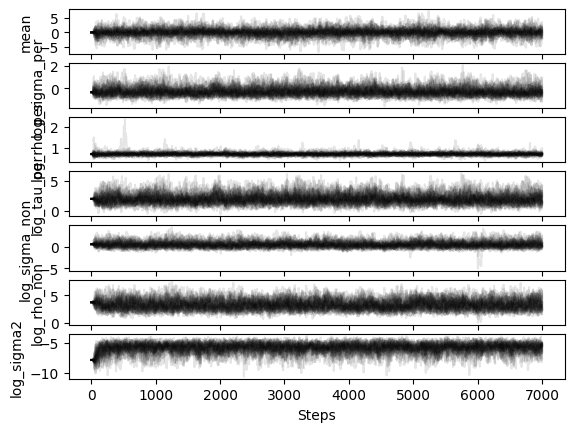

In [9]:
from simple.plot import chainplot

walk_chain = sampler.get_chain()

chainplot(walk_chain, labels=model.keys())
plt.show()

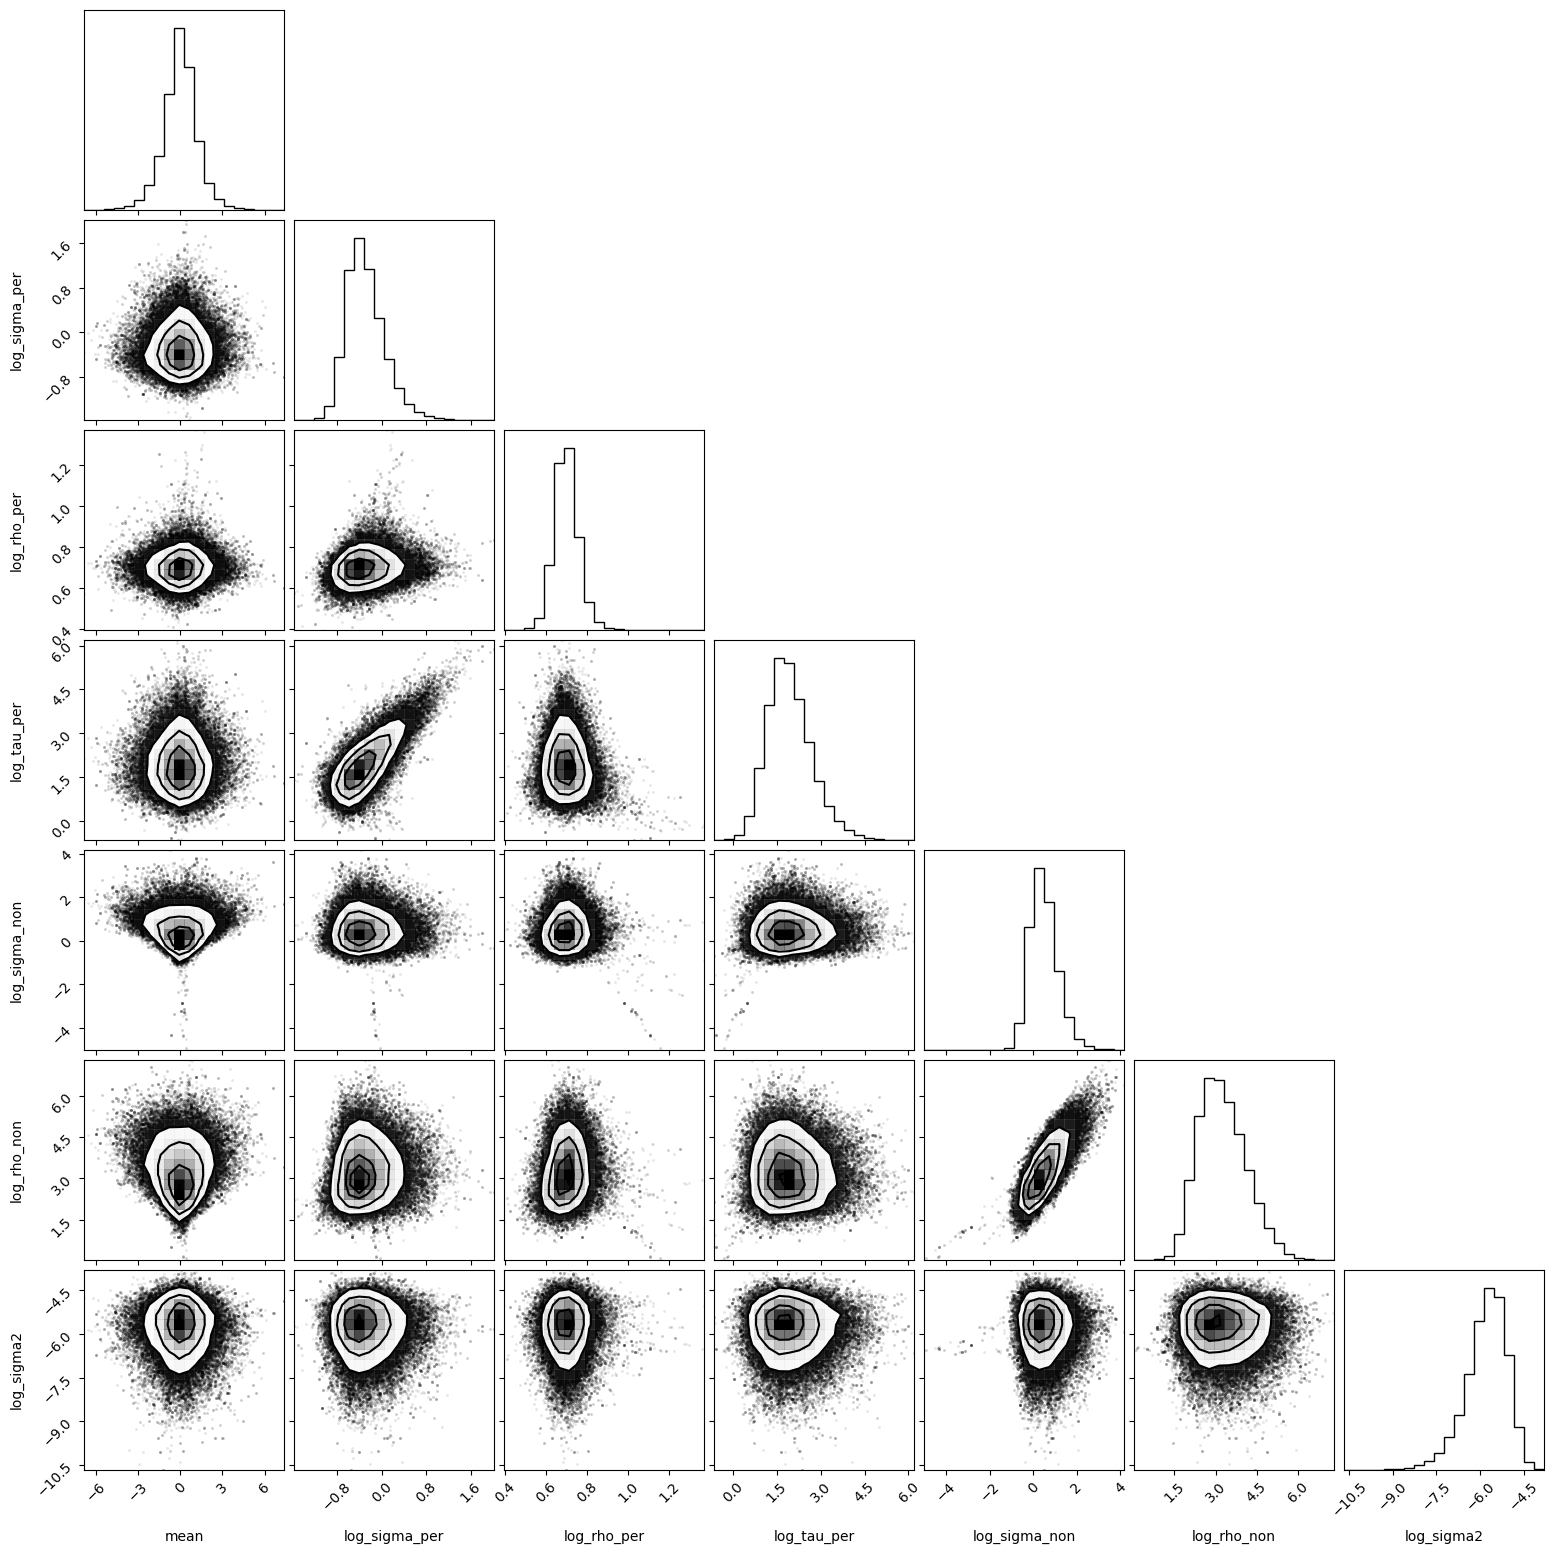

In [10]:
chain = sampler.get_chain(flat=True, discard=2000)

corner.corner(chain, labels=model.keys())
plt.show()

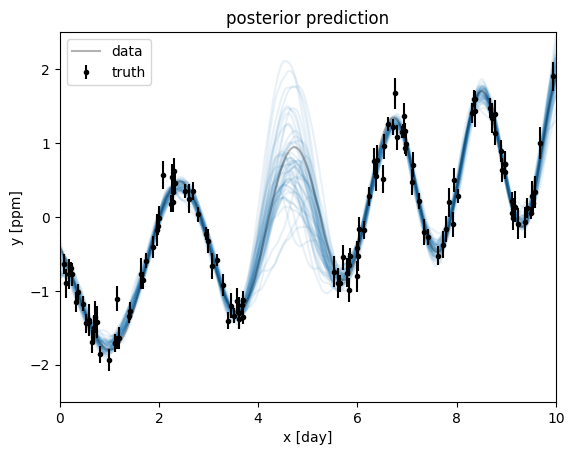

In [11]:
for sample in chain[np.random.randint(len(chain), size=50)]:
    sample_dict = dict(zip(model.keys(), sample, strict=True))
    gp = set_params(sample_dict, gp, t, yerr)
    conditional = gp.condition(y, true_t)
    plt.plot(true_t, conditional.sample(), color="C0", alpha=0.1)

plt.title("posterior prediction")
plot_prediction(None)
plt.show()

  0%|                                                                                                                                                                                                                                                                                            | 0/160000 [00:00<?, ?it/s]

  0%|▉                                                                                                                                                                                                                                                                               | 564/160000 [00:00<00:28, 5633.63it/s]

  1%|█▉                                                                                                                                                                                                                                                                             | 1142/160000 [00:00<00:27, 5719.17it/s]

  1%|██▉                                                                                                                                                                                                                                                                            | 1732/160000 [00:00<00:27, 5797.55it/s]

  1%|███▉                                                                                                                                                                                                                                                                           | 2312/160000 [00:00<00:27, 5730.59it/s]

  2%|████▉                                                                                                                                                                                                                                                                          | 2894/160000 [00:00<00:27, 5761.64it/s]

  2%|█████▉                                                                                                                                                                                                                                                                         | 3485/160000 [00:00<00:26, 5808.41it/s]

  3%|██████▉                                                                                                                                                                                                                                                                        | 4077/160000 [00:00<00:26, 5843.61it/s]

  3%|███████▉                                                                                                                                                                                                                                                                       | 4669/160000 [00:00<00:26, 5866.37it/s]

  3%|████████▉                                                                                                                                                                                                                                                                      | 5260/160000 [00:00<00:26, 5878.88it/s]

  4%|█████████▉                                                                                                                                                                                                                                                                     | 5849/160000 [00:01<00:26, 5881.72it/s]

  4%|██████████▉                                                                                                                                                                                                                                                                    | 6441/160000 [00:01<00:26, 5891.28it/s]

  4%|███████████▉                                                                                                                                                                                                                                                                   | 7031/160000 [00:01<00:26, 5872.79it/s]

  5%|████████████▉                                                                                                                                                                                                                                                                  | 7619/160000 [00:01<00:26, 5826.17it/s]

  5%|█████████████▉                                                                                                                                                                                                                                                                 | 8202/160000 [00:01<00:26, 5774.22it/s]

  5%|██████████████▊                                                                                                                                                                                                                                                                | 8780/160000 [00:01<00:26, 5738.49it/s]

  6%|███████████████▊                                                                                                                                                                                                                                                               | 9354/160000 [00:01<00:26, 5716.85it/s]

  6%|████████████████▊                                                                                                                                                                                                                                                              | 9926/160000 [00:01<00:26, 5692.33it/s]

  7%|█████████████████▋                                                                                                                                                                                                                                                            | 10496/160000 [00:01<00:27, 5388.59it/s]

  7%|██████████████████▋                                                                                                                                                                                                                                                           | 11039/160000 [00:01<00:29, 5115.67it/s]

  7%|███████████████████▌                                                                                                                                                                                                                                                          | 11565/160000 [00:02<00:28, 5155.17it/s]

  8%|████████████████████▍                                                                                                                                                                                                                                                         | 12084/160000 [00:02<00:29, 5048.53it/s]

  8%|█████████████████████▎                                                                                                                                                                                                                                                        | 12647/160000 [00:02<00:28, 5213.18it/s]

  8%|██████████████████████▎                                                                                                                                                                                                                                                       | 13198/160000 [00:02<00:27, 5298.53it/s]

  9%|███████████████████████▏                                                                                                                                                                                                                                                      | 13769/160000 [00:02<00:26, 5416.37it/s]

  9%|████████████████████████▏                                                                                                                                                                                                                                                     | 14340/160000 [00:02<00:26, 5501.20it/s]

  9%|█████████████████████████▏                                                                                                                                                                                                                                                    | 14915/160000 [00:02<00:26, 5572.43it/s]

 10%|██████████████████████████▏                                                                                                                                                                                                                                                   | 15495/160000 [00:02<00:25, 5637.29it/s]

 10%|███████████████████████████▏                                                                                                                                                                                                                                                  | 16077/160000 [00:02<00:25, 5689.38it/s]

 10%|████████████████████████████                                                                                                                                                                                                                                                  | 16655/160000 [00:02<00:25, 5715.79it/s]

 11%|█████████████████████████████                                                                                                                                                                                                                                                 | 17238/160000 [00:03<00:24, 5749.84it/s]

 11%|██████████████████████████████                                                                                                                                                                                                                                                | 17814/160000 [00:03<00:24, 5739.83it/s]

 11%|███████████████████████████████                                                                                                                                                                                                                                               | 18396/160000 [00:03<00:24, 5763.70it/s]

 12%|████████████████████████████████                                                                                                                                                                                                                                              | 18979/160000 [00:03<00:24, 5781.26it/s]

 12%|█████████████████████████████████                                                                                                                                                                                                                                             | 19561/160000 [00:03<00:24, 5791.15it/s]

 13%|█████████████████████████████████▉                                                                                                                                                                                                                                            | 20141/160000 [00:03<00:24, 5745.55it/s]

 13%|██████████████████████████████████▉                                                                                                                                                                                                                                           | 20716/160000 [00:03<00:24, 5737.32it/s]

 13%|███████████████████████████████████▉                                                                                                                                                                                                                                          | 21290/160000 [00:03<00:24, 5725.34it/s]

 14%|████████████████████████████████████▉                                                                                                                                                                                                                                         | 21870/160000 [00:03<00:24, 5745.27it/s]

 14%|█████████████████████████████████████▉                                                                                                                                                                                                                                        | 22445/160000 [00:03<00:24, 5729.42it/s]

 14%|██████████████████████████████████████▊                                                                                                                                                                                                                                       | 23018/160000 [00:04<00:23, 5707.95it/s]

 15%|███████████████████████████████████████▊                                                                                                                                                                                                                                      | 23589/160000 [00:04<00:24, 5593.15it/s]

 15%|████████████████████████████████████████▊                                                                                                                                                                                                                                     | 24171/160000 [00:04<00:24, 5658.00it/s]

 15%|█████████████████████████████████████████▊                                                                                                                                                                                                                                    | 24756/160000 [00:04<00:23, 5712.85it/s]

 16%|██████████████████████████████████████████▋                                                                                                                                                                                                                                   | 25328/160000 [00:04<00:23, 5661.58it/s]

 16%|███████████████████████████████████████████▋                                                                                                                                                                                                                                  | 25895/160000 [00:04<00:23, 5655.83it/s]

 17%|████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 26476/160000 [00:04<00:23, 5697.73it/s]

 17%|█████████████████████████████████████████████▋                                                                                                                                                                                                                                | 27046/160000 [00:04<00:23, 5680.37it/s]

 17%|██████████████████████████████████████████████▌                                                                                                                                                                                                                               | 27628/160000 [00:04<00:23, 5721.85it/s]

 18%|███████████████████████████████████████████████▌                                                                                                                                                                                                                              | 28203/160000 [00:04<00:23, 5728.34it/s]

 18%|████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 28776/160000 [00:05<00:23, 5642.94it/s]

 18%|█████████████████████████████████████████████████▌                                                                                                                                                                                                                            | 29341/160000 [00:05<00:24, 5417.93it/s]

 19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                           | 29885/160000 [00:05<00:25, 5053.66it/s]

 19%|███████████████████████████████████████████████████▎                                                                                                                                                                                                                          | 30414/160000 [00:05<00:25, 5119.02it/s]

 19%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                         | 30977/160000 [00:05<00:24, 5263.87it/s]

 20%|█████████████████████████████████████████████████████▏                                                                                                                                                                                                                        | 31508/160000 [00:05<00:25, 4950.12it/s]

 20%|██████████████████████████████████████████████████████                                                                                                                                                                                                                        | 32035/160000 [00:05<00:25, 5037.22it/s]

 20%|███████████████████████████████████████████████████████                                                                                                                                                                                                                       | 32608/160000 [00:05<00:24, 5233.42it/s]

 21%|████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 33191/160000 [00:05<00:23, 5403.58it/s]

 21%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 33776/160000 [00:06<00:22, 5531.75it/s]

 21%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                    | 34333/160000 [00:06<00:22, 5475.69it/s]

 22%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                                                   | 34883/160000 [00:06<00:24, 5101.41it/s]

 22%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 35400/160000 [00:06<00:26, 4792.06it/s]

 22%|████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 35887/160000 [00:06<00:26, 4615.08it/s]

 23%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 36354/160000 [00:06<00:26, 4590.22it/s]

 23%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 36937/160000 [00:06<00:24, 4934.64it/s]

 23%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                                              | 37508/160000 [00:06<00:23, 5153.89it/s]

 24%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                             | 38094/160000 [00:06<00:22, 5355.44it/s]

 24%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 38684/160000 [00:07<00:22, 5512.15it/s]

 25%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                           | 39271/160000 [00:07<00:21, 5616.21it/s]

 25%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 39855/160000 [00:07<00:21, 5680.25it/s]

 25%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 40442/160000 [00:07<00:20, 5735.19it/s]

 26%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                        | 41022/160000 [00:07<00:20, 5753.88it/s]

 26%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                       | 41599/160000 [00:07<00:20, 5756.06it/s]

 26%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 42188/160000 [00:07<00:20, 5795.97it/s]

 27%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                     | 42778/160000 [00:07<00:20, 5826.83it/s]

 27%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 43367/160000 [00:07<00:19, 5843.75it/s]

 27%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                   | 43957/160000 [00:07<00:19, 5859.29it/s]

 28%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 44544/160000 [00:08<00:19, 5837.19it/s]

 28%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 45131/160000 [00:08<00:19, 5845.55it/s]

 29%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 45716/160000 [00:08<00:19, 5844.51it/s]

 29%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 46305/160000 [00:08<00:19, 5855.64it/s]

 29%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 46897/160000 [00:08<00:19, 5872.29it/s]

 30%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                             | 47485/160000 [00:08<00:19, 5682.70it/s]

 30%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                             | 48055/160000 [00:08<00:19, 5625.73it/s]

 30%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                            | 48619/160000 [00:08<00:19, 5604.93it/s]

 31%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 49181/160000 [00:08<00:19, 5548.82it/s]

 31%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                          | 49737/160000 [00:08<00:20, 5507.87it/s]

 31%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 50289/160000 [00:09<00:20, 5435.67it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 50833/160000 [00:09<00:20, 5381.79it/s]

 32%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 51372/160000 [00:09<00:20, 5347.48it/s]

 32%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                      | 51929/160000 [00:09<00:19, 5411.70it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 52514/160000 [00:09<00:19, 5538.75it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                    | 53102/160000 [00:09<00:18, 5639.81it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 53691/160000 [00:09<00:18, 5711.67it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 54272/160000 [00:09<00:18, 5738.46it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 54864/160000 [00:09<00:18, 5789.86it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 55453/160000 [00:09<00:17, 5818.21it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 56045/160000 [00:10<00:17, 5846.81it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 56635/160000 [00:10<00:17, 5859.64it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                             | 57222/160000 [00:10<00:17, 5834.60it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 57806/160000 [00:10<00:17, 5825.65it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 58389/160000 [00:10<00:17, 5712.04it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 58961/160000 [00:10<00:17, 5670.30it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 59529/160000 [00:10<00:18, 5581.72it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 60088/160000 [00:10<00:18, 5445.14it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 60634/160000 [00:10<00:18, 5436.79it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 61179/160000 [00:10<00:18, 5369.30it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 61744/160000 [00:11<00:18, 5448.53it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 62326/160000 [00:11<00:17, 5556.40it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 62912/160000 [00:11<00:17, 5645.26it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 63478/160000 [00:11<00:17, 5523.65it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 64032/160000 [00:11<00:17, 5499.07it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 64599/160000 [00:11<00:17, 5548.54it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 65184/160000 [00:11<00:16, 5635.76it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                               | 65772/160000 [00:11<00:16, 5708.23it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 66344/160000 [00:11<00:16, 5654.20it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 66910/160000 [00:12<00:16, 5646.00it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 67475/160000 [00:12<00:16, 5620.21it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 68049/160000 [00:12<00:16, 5654.56it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 68615/160000 [00:12<00:16, 5628.53it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 69178/160000 [00:12<00:16, 5594.62it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 69738/160000 [00:12<00:16, 5552.37it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 70294/160000 [00:12<00:16, 5417.89it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 70837/160000 [00:12<00:16, 5266.40it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 71365/160000 [00:12<00:16, 5223.79it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 71893/160000 [00:12<00:16, 5238.75it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 72418/160000 [00:13<00:16, 5162.45it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 72956/160000 [00:13<00:16, 5224.96it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 73502/160000 [00:13<00:16, 5291.59it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 74032/160000 [00:13<00:16, 5227.76it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 74578/160000 [00:13<00:16, 5295.33it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 75130/160000 [00:13<00:15, 5360.93it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 75667/160000 [00:13<00:15, 5303.21it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 76217/160000 [00:13<00:15, 5358.64it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 76771/160000 [00:13<00:15, 5410.69it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 77319/160000 [00:13<00:15, 5430.83it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 77873/160000 [00:14<00:15, 5462.67it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 78427/160000 [00:14<00:14, 5483.68it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 78976/160000 [00:14<00:15, 5185.26it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 79498/160000 [00:14<00:15, 5103.86it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 80011/160000 [00:14<00:16, 4964.71it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 80514/160000 [00:14<00:15, 4982.06it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 81014/160000 [00:14<00:16, 4917.79it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 81508/160000 [00:14<00:15, 4922.51it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 82001/160000 [00:14<00:16, 4759.96it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 82479/160000 [00:15<00:16, 4673.09it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 82948/160000 [00:15<00:16, 4604.16it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 83415/160000 [00:15<00:16, 4622.30it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 83891/160000 [00:15<00:16, 4661.58it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 84363/160000 [00:15<00:16, 4678.48it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 84856/160000 [00:15<00:15, 4751.70it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 85343/160000 [00:15<00:15, 4785.91it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 85822/160000 [00:15<00:16, 4418.86it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 86270/160000 [00:15<00:17, 4206.08it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 86713/160000 [00:15<00:17, 4267.31it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 87183/160000 [00:16<00:16, 4388.57it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 87626/160000 [00:16<00:16, 4300.26it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 88078/160000 [00:16<00:16, 4363.21it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 88517/160000 [00:16<00:16, 4319.86it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 88971/160000 [00:16<00:16, 4383.07it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 89411/160000 [00:16<00:16, 4378.53it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 89859/160000 [00:16<00:15, 4406.68it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 90337/160000 [00:16<00:15, 4515.46it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 90814/160000 [00:16<00:15, 4590.73it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 91285/160000 [00:16<00:14, 4626.24it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 91763/160000 [00:17<00:14, 4670.04it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 92234/160000 [00:17<00:14, 4680.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 92716/160000 [00:17<00:14, 4720.12it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 93189/160000 [00:17<00:14, 4694.96it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 93659/160000 [00:17<00:14, 4527.76it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 94114/160000 [00:17<00:14, 4450.43it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 94561/160000 [00:17<00:15, 4246.49it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 94993/160000 [00:17<00:15, 4265.20it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 95422/160000 [00:17<00:16, 3962.06it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 95900/160000 [00:18<00:15, 4185.96it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 96385/160000 [00:18<00:14, 4372.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 96896/160000 [00:18<00:13, 4583.51it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 97359/160000 [00:18<00:14, 4227.36it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 97856/160000 [00:18<00:14, 4432.00it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 98431/160000 [00:18<00:12, 4803.44it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 99010/160000 [00:18<00:11, 5086.62it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 99593/160000 [00:18<00:11, 5302.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 100169/160000 [00:18<00:11, 5435.71it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 100717/160000 [00:18<00:11, 5316.85it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 101290/160000 [00:19<00:10, 5436.14it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 101871/160000 [00:19<00:10, 5545.18it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 102437/160000 [00:19<00:10, 5577.23it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 103005/160000 [00:19<00:10, 5607.18it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 103575/160000 [00:19<00:10, 5634.08it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 104143/160000 [00:19<00:09, 5646.59it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 104709/160000 [00:19<00:09, 5646.80it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 105275/160000 [00:19<00:10, 5438.18it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 105821/160000 [00:19<00:10, 5193.04it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 106344/160000 [00:20<00:10, 5055.44it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 106852/160000 [00:20<00:11, 4770.30it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 107333/160000 [00:20<00:11, 4652.12it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 107801/160000 [00:20<00:11, 4611.16it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 108264/160000 [00:20<00:11, 4368.73it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 108704/160000 [00:20<00:12, 4167.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 109124/160000 [00:20<00:12, 4049.22it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 109531/160000 [00:20<00:12, 3978.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 109930/160000 [00:20<00:12, 3915.21it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 110322/160000 [00:21<00:13, 3795.40it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 110702/160000 [00:21<00:13, 3650.95it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 111068/160000 [00:21<00:13, 3625.80it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 111431/160000 [00:21<00:14, 3456.40it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 111793/160000 [00:21<00:13, 3499.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 112145/160000 [00:21<00:13, 3479.92it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 112512/160000 [00:21<00:13, 3532.47it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 112866/160000 [00:21<00:13, 3531.59it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 113220/160000 [00:21<00:13, 3504.23it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 113589/160000 [00:21<00:13, 3557.90it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 113966/160000 [00:22<00:12, 3617.27it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 114365/160000 [00:22<00:12, 3725.26it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 114769/160000 [00:22<00:11, 3816.95it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 115169/160000 [00:22<00:11, 3871.40it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 115567/160000 [00:22<00:11, 3902.69it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 115979/160000 [00:22<00:11, 3964.61it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 116405/160000 [00:22<00:10, 4051.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 116870/160000 [00:22<00:10, 4228.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 117326/160000 [00:22<00:09, 4326.12it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 117759/160000 [00:22<00:09, 4251.75it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 118185/160000 [00:23<00:10, 4143.51it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 118601/160000 [00:23<00:10, 4109.15it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 119013/160000 [00:23<00:10, 4021.94it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 119416/160000 [00:23<00:10, 4012.52it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 119824/160000 [00:23<00:09, 4029.65it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 120228/160000 [00:23<00:10, 3933.02it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 120622/160000 [00:23<00:10, 3854.16it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 121008/160000 [00:23<00:10, 3850.63it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 121426/160000 [00:23<00:09, 3944.91it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 121821/160000 [00:24<00:09, 3932.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 122215/160000 [00:24<00:09, 3926.42it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 122648/160000 [00:24<00:09, 4044.19it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 123053/160000 [00:24<00:09, 4000.97it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 123484/160000 [00:24<00:08, 4091.69it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 123952/160000 [00:24<00:08, 4264.27it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 124413/160000 [00:24<00:08, 4365.43it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 124894/160000 [00:24<00:07, 4497.96it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 125394/160000 [00:24<00:07, 4647.67it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 125860/160000 [00:24<00:07, 4562.72it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 126317/160000 [00:25<00:07, 4282.41it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 126749/160000 [00:25<00:09, 3596.93it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 127129/160000 [00:25<00:09, 3453.04it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 127492/160000 [00:25<00:09, 3497.93it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 127893/160000 [00:25<00:08, 3633.67it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 128330/160000 [00:25<00:08, 3835.63it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 128755/160000 [00:25<00:07, 3950.57it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 129214/160000 [00:25<00:07, 4132.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 129702/160000 [00:25<00:06, 4349.12it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 130207/160000 [00:26<00:06, 4553.32it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 130733/160000 [00:26<00:06, 4761.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 131272/160000 [00:26<00:05, 4948.09it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 131792/160000 [00:26<00:05, 5020.96it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 132340/160000 [00:26<00:05, 5157.24it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 132897/160000 [00:26<00:05, 5278.43it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 133465/160000 [00:26<00:04, 5396.60it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 134035/160000 [00:26<00:04, 5485.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 134620/160000 [00:26<00:04, 5591.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 135180/160000 [00:26<00:04, 5584.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 135739/160000 [00:27<00:04, 5324.46it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 136275/160000 [00:27<00:04, 5054.79it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 136785/160000 [00:27<00:04, 5039.50it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 137292/160000 [00:27<00:04, 4911.33it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 137786/160000 [00:27<00:04, 4743.95it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 138263/160000 [00:27<00:04, 4641.21it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 138734/160000 [00:27<00:04, 4657.92it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 139201/160000 [00:27<00:04, 4571.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 139659/160000 [00:27<00:04, 4555.01it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 140115/160000 [00:28<00:04, 4525.12it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 140592/160000 [00:28<00:04, 4595.30it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 141052/160000 [00:28<00:04, 4536.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 141524/160000 [00:28<00:04, 4588.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 142025/160000 [00:28<00:03, 4710.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 142544/160000 [00:28<00:03, 4851.19it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 143082/160000 [00:28<00:03, 5007.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 143631/160000 [00:28<00:03, 5150.98it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 144192/160000 [00:28<00:02, 5286.19it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 144758/160000 [00:28<00:02, 5395.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 145324/160000 [00:29<00:02, 5473.96it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 145902/160000 [00:29<00:02, 5564.19it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 146469/160000 [00:29<00:02, 5592.93it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 147036/160000 [00:29<00:02, 5613.24it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 147603/160000 [00:29<00:02, 5629.01it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 148171/160000 [00:29<00:02, 5641.67it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 148754/160000 [00:29<00:01, 5696.42it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 149339/160000 [00:29<00:01, 5741.27it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 149925/160000 [00:29<00:01, 5774.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 150506/160000 [00:29<00:01, 5782.63it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 151085/160000 [00:30<00:01, 5557.82it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 151643/160000 [00:30<00:01, 5320.08it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 152178/160000 [00:30<00:01, 5121.37it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 152694/160000 [00:30<00:01, 5081.69it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 153205/160000 [00:30<00:01, 4931.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 153700/160000 [00:30<00:01, 4915.17it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 154212/160000 [00:30<00:01, 4971.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 154746/160000 [00:30<00:01, 5076.25it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 155297/160000 [00:30<00:00, 5202.68it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 155861/160000 [00:30<00:00, 5329.93it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 156395/160000 [00:31<00:00, 5258.19it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 156922/160000 [00:31<00:00, 4851.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 157414/160000 [00:31<00:00, 4806.15it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 157914/160000 [00:31<00:00, 4860.20it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 158436/160000 [00:31<00:00, 4961.62it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 158935/160000 [00:31<00:00, 4924.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 159430/160000 [00:31<00:00, 4833.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 159919/160000 [00:31<00:00, 4847.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160000/160000 [00:31<00:00, 5022.04it/s]

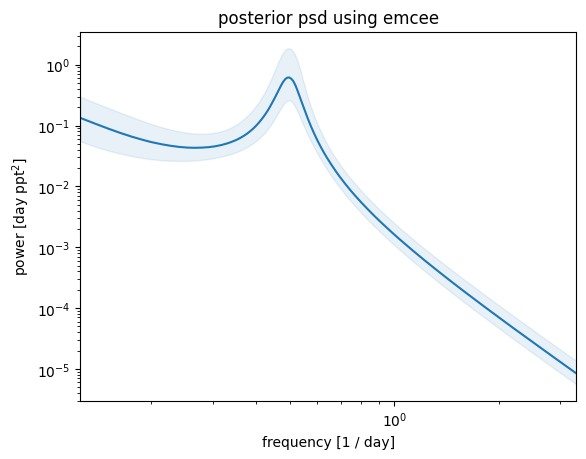

In [12]:
import tqdm

psds = np.empty((chain.shape[0], omega.size))
for i, sample in enumerate(tqdm.tqdm(chain)):
    sample_dict = dict(zip(model.keys(), sample, strict=True))
    gp = set_params(sample_dict, gp, t, yerr)
    psds[i] = gp.kernel.get_psd(omega)

q = np.percentile(psds, [16, 50, 84], axis=0)

plt.loglog(freq, q[1], color="C0")
plt.fill_between(freq, q[0], q[2], color="C0", alpha=0.1)

plt.xlim(freq.min(), freq.max())
plt.xlabel("frequency [1 / day]")
plt.ylabel("power [day ppt$^2$]")
_ = plt.title("posterior psd using emcee")
plt.show()